`Financial Time Series`

### set-up

In [1]:
# %pip install ta==0.9.0
# %pip install shap

In [ ]:
"""
mlfinlab
"""

"""
Module which implements feature importance algorithms as described in Chapter 8 of Advances in Financial Machine
Learning and Clustered Feature Importance algorithms as described in Chapter 6 Section 6.5.2 of Machine Learning for
Asset Managers.
"""

import pandas as pd
import numpy as np
from sklearn.metrics import log_loss


def mean_decrease_impurity(model, feature_names, clustered_subsets=None):
    """
    Advances in Financial Machine Learning, Snippet 8.2, page 115.
    MDI Feature importance
    Mean decrease impurity (MDI) is a fast, explanatory-importance (in-sample, IS) method specific to tree-based
    classifiers, like RF. At each node of each decision tree, the selected feature splits the subset it received in
    such a way that impurity is decreased. Therefore, we can derive for each decision tree how much of the overall
    impurity decrease can be assigned to each feature. And given that we have a forest of trees, we can average those
    values across all estimators and rank the features accordingly.
    Tip:
    Masking effects take place when some features are systematically ignored by tree-based classifiers in favor of
    others. In order to avoid them, set max_features=int(1) when using sklearn’s RF class. In this way, only one random
    feature is considered per level.
    Notes:
    * MDI cannot be generalized to other non-tree based classifiers
    * The procedure is obviously in-sample.
    * Every feature will have some importance, even if they have no predictive power whatsoever.
    * MDI has the nice property that feature importances add up to 1, and every feature importance is bounded between 0 and 1.
    * method does not address substitution effects in the presence of correlated features. MDI dilutes the importance of
      substitute features, because of their interchangeability: The importance of two identical features will be halved,
      as they are randomly chosen with equal probability.
    * Sklearn’s RandomForest class implements MDI as the default feature importance score. This choice is likely
      motivated by the ability to compute MDI on the fly, with minimum computational cost.
    Clustered Feature Importance( Machine Learning for Asset Manager snippet 6.4 page 86) :
    Clustered MDI  is the  modified version of MDI (Mean Decreased Impurity). It  is robust to substitution effect that
    takes place when two or more explanatory variables share a substantial amount of information (predictive power).CFI
    algorithm described by Dr Marcos Lopez de Prado  in Clustered Feature  Importance section of book Machine Learning
    for Asset Manager. Here  instead of  taking the importance  of  every feature, we consider the importance of every
    feature subsets, thus every feature receive the importance of subset it belongs to.
    :param model: (model object): Trained tree based classifier.
    :param feature_names: (list): Array of feature names.
    :param clustered_subsets: (list) Feature clusters for Clustered Feature Importance (CFI). Default None will not apply CFI.
                              Structure of the input must be a list of list/s i.e. a list containing the clusters/subsets of feature
                              name/s inside a list. E.g- [['I_0','I_1','R_0','R_1'],['N_1','N_2'],['R_3']]
    :return: (pd.DataFrame): Mean and standard deviation feature importance.
    """
    # Feature importance based on in-sample (IS) mean impurity reduction
    feature_imp_df = {i: tree.feature_importances_ for i, tree in enumerate(model.estimators_)}
    feature_imp_df = pd.DataFrame.from_dict(feature_imp_df, orient='index')
    feature_imp_df.columns = feature_names

    # Make sure that features with zero importance are not averaged, since the only reason for a 0 is that the feature
    # was not randomly chosen. Replace those values with np.nan
    feature_imp_df = feature_imp_df.replace(0, np.nan)  # Because max_features = 1

    if clustered_subsets is not None:
        # Getting subset wise importance
        importance = pd.DataFrame(index=feature_names, columns=['mean', 'std'])
        for subset in clustered_subsets: # Iterating over each cluster
            subset_feat_imp = feature_imp_df[subset].sum(axis=1)
            # Importance of each feature within a subsets is equal to the importance of that subset
            importance.loc[subset, 'mean'] = subset_feat_imp.mean()
            importance.loc[subset, 'std'] = subset_feat_imp.std()*subset_feat_imp.shape[0]**-.5
    else:
        importance = pd.concat({'mean': feature_imp_df.mean(),
                                'std': feature_imp_df.std() * feature_imp_df.shape[0] ** -0.5},
                               axis=1)

    importance /= importance['mean'].sum()
    return importance


def mean_decrease_accuracy(model, X, y, cv_gen, clustered_subsets=None, sample_weight_train=None,
                           sample_weight_score=None, scoring=log_loss, random_state=42):
    """
    Advances in Financial Machine Learning, Snippet 8.3, page 116-117.
    MDA Feature Importance
    Mean decrease accuracy (MDA) is a slow, predictive-importance (out-of-sample, OOS) method. First, it fits a
    classifier; second, it derives its performance OOS according to some performance score (accuracy, negative log-loss,
    etc.); third, it permutates each column of the features matrix (X), one column at a time, deriving the performance
    OOS after each column’s permutation. The importance of a feature is a function of the loss in performance caused by
    its column’s permutation. Some relevant considerations include:
    * This method can be applied to any classifier, not only tree-based classifiers.
    * MDA is not limited to accuracy as the sole performance score. For example, in the context of meta-labeling
      applications, we may prefer to score a classifier with F1 rather than accuracy. That is one reason a better
      descriptive name would have been “permutation importance.” When the scoring function does not correspond to a
      metric space, MDA results should be used as a ranking.
    * Like MDI, the procedure is also susceptible to substitution effects in the presence of correlated features.
      Given two identical features, MDA always considers one to be redundant to the other. Unfortunately, MDA will make
      both features appear to be outright irrelevant, even if they are critical.
    * Unlike MDI, it is possible that MDA concludes that all features are unimportant. That is because MDA is based on
      OOS performance.
    * The CV must be purged and embargoed.
    Clustered Feature Importance( Machine Learning for Asset Manager snippet 6.5 page 87) :
    Clustered MDA is the modified version of MDA (Mean Decreased Accuracy). It is robust to substitution effect that takes
    place when two or more explanatory variables share a substantial amount of information (predictive power).CFI algorithm
    described by Dr Marcos Lopez de Prado  in Clustered Feature  Importance (Presentation Slides)
    https://papers.ssrn.com/sol3/papers.cfm?abstract_id=3517595. Instead of shuffling (permutating) all variables
    individually (like in MDA), we shuffle all variables in cluster together. Next, we follow all the  rest of the
    steps as in MDA. It can used by simply specifying the clustered_subsets argument.
    :param model: (sklearn.Classifier): Any sklearn classifier.
    :param X: (pd.DataFrame): Train set features.
    :param y: (pd.DataFrame, np.array): Train set labels.
    :param cv_gen: (cross_validation.PurgedKFold): Cross-validation object.
    :param clustered_subsets: (list) Feature clusters for Clustered Feature Importance (CFI). Default None will not apply CFI.
                              Structure of the input must be a list of list/s i.e. a list containing the clusters/subsets of feature
                              name/s inside a list. E.g- [['I_0','I_1','R_0','R_1'],['N_1','N_2'],['R_3']]
    :param sample_weight_train: (np.array) Sample weights used to train the model for each record in the dataset.
    :param sample_weight_score: (np.array) Sample weights used to evaluate the model quality.
    :param scoring: (function): Scoring function used to determine importance.
    :param random_state: (int) Random seed for shuffling the features.
    :return: (pd.DataFrame): Mean and standard deviation of feature importance.
    """

    if sample_weight_train is None:
        sample_weight_train = np.ones((X.shape[0],))

    if sample_weight_score is None:
        sample_weight_score = np.ones((X.shape[0],))

    fold_metrics_values, features_metrics_values = pd.Series(dtype='float64'), pd.DataFrame(columns=X.columns)
    # Generating a numpy random state object for the given random_state
    rs_obj = np.random.RandomState(seed=random_state)
    # Clustered feature subsets will be used for CFI if clustered_subsets exists else will operate on the single column as MDA
    feature_sets = clustered_subsets if clustered_subsets else [[x] for x in X.columns]
    for i, (train, test) in enumerate(cv_gen.split(X=X)):
        fit = model.fit(X=X.iloc[train, :], y=y.iloc[train], sample_weight=sample_weight_train[train])
        pred = fit.predict(X.iloc[test, :])

        # Get overall metrics value on out-of-sample fold
        if scoring == log_loss:
            prob = fit.predict_proba(X.iloc[test, :])
            fold_metrics_values.loc[i] = -scoring(y.iloc[test], prob, sample_weight=sample_weight_score[test],
                                                  labels=model.classes_)
        else:
            fold_metrics_values.loc[i] = scoring(y.iloc[test], pred, sample_weight=sample_weight_score[test])

        # Get feature specific metric on out-of-sample fold
        for j in feature_sets:
            X1_ = X.iloc[test, :].copy(deep=True)
            for j_i in j:
                rs_obj.shuffle(X1_[j_i].values)  # Permutation of a single column for MDA or through the whole subset for CFI
            if scoring == log_loss:
                prob = fit.predict_proba(X1_)
                features_metrics_values.loc[i, j] = -scoring(y.iloc[test], prob,
                                                             sample_weight=sample_weight_score[test],
                                                             labels=model.classes_)
            else:
                pred = fit.predict(X1_)
                features_metrics_values.loc[i, j] = scoring(y.iloc[test], pred,
                                                            sample_weight=sample_weight_score[test])

    importance = (-features_metrics_values).add(fold_metrics_values, axis=0)
    if scoring == log_loss:
        importance = importance / -features_metrics_values
    else:
        importance = importance / (1.0 - features_metrics_values).replace(0, np.nan)
    importance = pd.concat({'mean': importance.mean(), 'std': importance.std() * importance.shape[0] ** -.5}, axis=1)
    importance.replace([-np.inf, np.nan], 0, inplace=True)  # Replace infinite values

    return importance


"""
Created on Fri Dec  6 19:41:30 2019

@author: sukji
"""
from typing import Callable
import pandas as pd
import numpy as np

from sklearn.metrics import log_loss
from sklearn.model_selection import KFold
from sklearn.base import ClassifierMixin
from sklearn.model_selection import BaseCrossValidator

def ml_get_train_times1(samples_info_sets: pd.Series, test_times: pd.Series) -> pd.Series:
    # pylint: disable=invalid-name
    """
    Advances in Financial Machine Learning, Snippet 7.1, page 106.

    Purging observations in the training set

    This function find the training set indexes given the information on which each record is based
    and the range for the test set.
    Given test_times, find the times of the training observations.

    :param samples_info_sets: (pd.Series) The information range on which each record is constructed from
        *samples_info_sets.index*: Time when the information extraction started.
        *samples_info_sets.value*: Time when the information extraction ended.
    :param test_times: (pd.Series) Times for the test dataset.
    :return: (pd.Series) Training set
    """
    train = samples_info_sets.copy(deep=True)

    start = test_times.min()
    end = test_times.max()

    first = test_times.index[0]
    last = test_times.index[-1]

    df0 = train[(train < first) | (train.index > end)].index  # Train starts within test
    return df0

class PKFold(KFold):
    """
    Extend KFold class to work with labels that span intervals

    The train is purged of observations overlapping test-label intervals
    Test set is assumed contiguous (shuffle=False), w/o training samples in between

    :param n_splits: (int) The number of splits. Default to 3
    :param samples_info_sets: (pd.Series) The information range on which each record is constructed from
        *samples_info_sets.index*: Time when the information extraction started.
        *samples_info_sets.value*: Time when the information extraction ended.
    :param pct_embargo: (float) Percent that determines the embargo size.
    """

    def __init__(self,
                 n_splits: int = 3,
                 samples_info_sets: pd.Series = None,
                 pct_embargo: float = 0.):

        if not isinstance(samples_info_sets, pd.Series):
            raise ValueError('The samples_info_sets param must be a pd.Series')
        super(PKFold, self).__init__(n_splits, shuffle=False, random_state=None)

        self.samples_info_sets = samples_info_sets
        self.pct_embargo = pct_embargo

    # noinspection PyPep8Naming
    def split(self,
              X: pd.DataFrame,
              y: pd.Series = None,
              groups=None):
        """
        The main method to call for the PurgedKFold class

        :param X: (pd.DataFrame) Samples dataset that is to be split
        :param y: (pd.Series) Sample labels series
        :param groups: (array-like), with shape (n_samples,), optional
            Group labels for the samples used while splitting the dataset into
            train/test set.
        :return: (tuple) [train list of sample indices, and test list of sample indices]
        """
        if X.shape[0] != self.samples_info_sets.shape[0]:
            raise ValueError("X and the 'samples_info_sets' series param must be the same length")

        indices: np.ndarray = np.arange(X.shape[0])
        embargo: int = int(X.shape[0] * self.pct_embargo)

        test_ranges: [(int, int)] = [(ix[0], ix[-1] + 1) for ix in np.array_split(np.arange(X.shape[0]), self.n_splits)]
        for start_ix, end_ix in test_ranges:
            test_indices = indices[start_ix:end_ix]

            if end_ix < X.shape[0]:
                end_ix += embargo

            test_times = pd.Series(index=[self.samples_info_sets.index[start_ix]], data=[self.samples_info_sets[end_ix-1]])
            #train_times = ml_get_train_times(self.samples_info_sets, test_times)
            train_times = ml_get_train_times1(self.samples_info_sets, test_times)

            train_indices = []
            for train_ix in train_times:
                train_indices.append(self.samples_info_sets.index.get_loc(train_ix))
            yield np.array(train_indices), test_indices

## 데이터 살펴보기

In [3]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

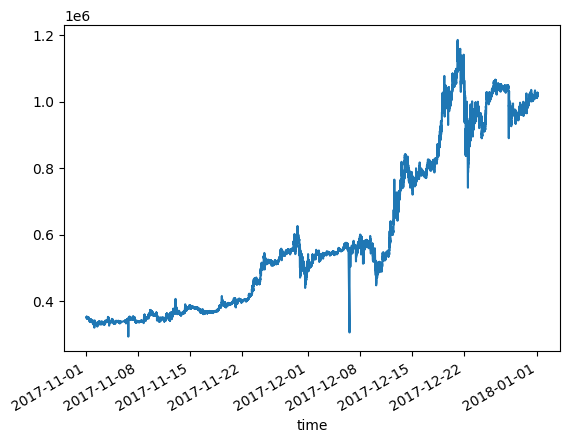

In [4]:
# load the dataset
DATA_PATH = '/Users/kwonkyoungmi/workspaces/workspace_Python/data/TS/'
modify_data = pd.read_csv(os.path.join(DATA_PATH, 'sub_upbit_eth_min_tick.csv'), index_col=0, parse_dates=True)
modify_data.loc['2017-11-01':'2017-12-31','close'].plot()
plt.show()

In [5]:
modify_data.head(45)

,open,high,low,close,volume
time,,,,,
2017-09-25 03:00:00,324500,325500,322000,324000,52.477251
2017-09-25 03:01:00,324000,324000,322500,324000,39.061889
2017-09-25 03:02:00,322500,324500,322500,324500,12.794000
2017-09-25 03:05:00,324000,324000,323000,324000,33.365246
2017-09-25 03:06:00,324000,325000,322500,324000,46.224544
2017-09-25 03:07:00,324000,324000,323000,323000,10.813594
2017-09-25 03:10:00,324000,325000,322500,323000,38.059644
2017-09-25 03:11:00,323000,325500,323000,323000,55.778813
2017-09-25 03:12:00,324000,324500,324000,324500,20.186029


## Label

### Price Change Direction

In [6]:
window = 10
momentum_signal = np.sign(np.sign(modify_data['close'] - modify_data['close'].shift(window)) + 1) #calculate momentum signal
s_momentum_signal = pd.Series(momentum_signal, index=modify_data.index)

In [7]:
s_momentum_signal

time
2017-09-25 03:00:00    NaN
2017-09-25 03:01:00    NaN
2017-09-25 03:02:00    NaN
2017-09-25 03:05:00    NaN
2017-09-25 03:06:00    NaN
                      ... 
2019-11-03 10:29:00    1.0
2019-11-03 10:30:00    0.0
2019-11-03 10:31:00    0.0
2019-11-03 10:32:00    0.0
2019-11-03 10:33:00    0.0
Name: close, Length: 1000000, dtype: float64

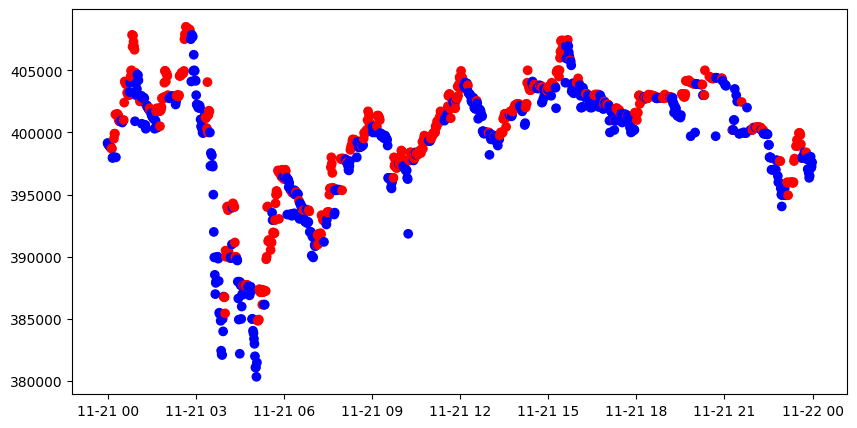

In [8]:
sub_data = modify_data.loc['2017-11-21', 'close']
c_sig = s_momentum_signal.loc['2017-11-21']
c_sig['color'] = np.where(c_sig == 1, 'red', 'blue')

plt.figure(figsize=(10,5))
plt.scatter(sub_data.index, sub_data, c=c_sig['color'])
plt.show()

### Moving Average
 현재의 주가가 특정 이동평균선 위에 있는지, 아래에 있는지 여부로 Labeling을 하는 방식

In [ ]:
# momentun_signal
window = 10
momentum_signal = np.sign(np.sign(modify_data['close'] - modify_data['close'].rolling(window).mean()) + 1) # - modify_data['close'].rolling(window).mean())
s_momentum_signal = pd.Series(momentum_signal, index=modify_data.index)

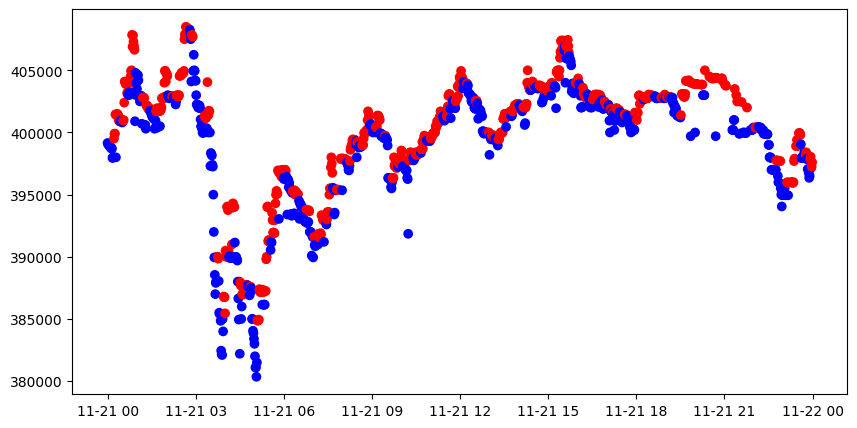

In [10]:
sub_data = modify_data.loc['2017-11-21', 'close']
c_sig = s_momentum_signal.loc['2017-11-21']
c_sig['color'] = np.where(c_sig == 1, 'red', 'blue')

plt.figure(figsize=(10,5))
plt.scatter(sub_data.index, sub_data, c=c_sig['color'])
plt.show()

### Local Min-Max
국지적인 최소 / 최대값을 계속 갱신하여, 최소-최대 구간을 이어나가며 Labeling하는 방식       
순차적인 가격 확인이 요구되는 만큼 데이터가 증가하면, 선형적으로 연산시간도 늘어나는 단점       

In [11]:
# Local min / max 를 추출하기 위한 함수
def get_local_min_max(close, wait=3):
    min_value = close.iloc[0]
    max_value = close.iloc[0]
    n_cnt_min, n_cnt_max = 0, 0
    
    mins, maxes = [], []
    min_idxes, max_idxes = [], []
    b_min_update, b_max_update = False, False
    
    for idx, val in zip(close.index[1:], close.values[1:]):
        if val < min_value:
            min_value = val
            mins.append(min_value)
            min_idxes.append(idx)
            n_cnt_min = 0
            b_min_update = True
        if val > max_value:
            max_value = val
            maxes.append(max_value)
            max_idxes.append(idx)
            n_cnt_max = 0
            b_max_update = True
        
        if not b_max_update:
            b_min_update = False
            n_cnt_min += 1
            if n_cnt_min >= wait:
                max_value = min_value
                n_cnt_min = 0
    
        if not b_min_update:
            b_max_update = False
            n_cnt_max += 1
            if n_cnt_max >= wait:
                min_value = max_value
                n_cnt_max = 0
               
    return pd.DataFrame.from_dict({'min_time': min_idxes, 'local_min': mins}), pd.DataFrame.from_dict({'max_time': max_idxes, 'local_max': maxes})

In [12]:
sub_data = modify_data.loc['2017-11-21', 'close']
mins, maxes = get_local_min_max(sub_data, wait=3)

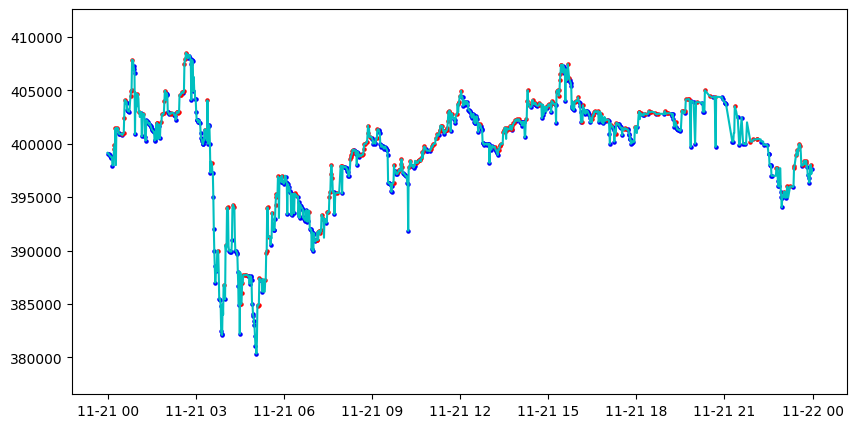

In [13]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.plot(sub_data, 'c')
ax.scatter(mins.min_time, mins.local_min, c='blue', s=5)
ax.scatter(maxes.max_time, maxes.local_max, c='red', s=5)
ax.set_ylim([sub_data.min() * 0.99, sub_data.max()  * 1.01])
plt.show()

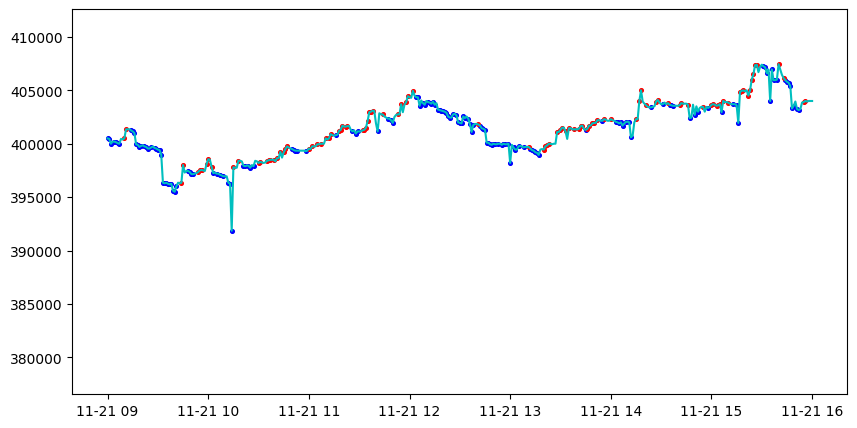

In [14]:
st_time, ed_time = '2017-11-21 09:00:00', '2017-11-21 16:00:00'

fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.plot(sub_data.loc[st_time:ed_time], 'c')
ax.scatter(mins.set_index('min_time', drop=False).min_time.loc[st_time:ed_time], mins.set_index('min_time').local_min.loc[st_time:ed_time], c='blue', s=7)
ax.scatter(maxes.set_index('max_time', drop=False).max_time.loc[st_time:ed_time], maxes.set_index('max_time').local_max.loc[st_time:ed_time], c='red', s=7)
ax.set_ylim([sub_data.min() * 0.99, sub_data.max()  * 1.01])
plt.show()

In [15]:
mins.shape[0], maxes.shape[0]

(477, 273)

### Trend Scanning
Trend Scanning은 Marcos Lopez de Prado 의 저서 'Machine Learning for Asset Managers'에 소개된 Labeling 방식     

[Hudson & Thames 가 공개한 MLFinLab 패키지의 코드를 활용](https://github.com/hudson-and-thames/mlfinlab)

In [ ]:
def t_val_lin_r(close):

    # t-value from a linear trend
    import statsmodels.api as sml
    import statsmodels.api as sm # 통계 모델을 구현하는 라이브러리 (OLS, 시계열 분석 등)

    # --- 회귀 분석을 위한 독립 변수 (x) 생성 ---
    # close는 분석하려는 시계열 데이터(주식 종가)
    # 이 데이터의 길이에 맞춰 x 배열을 생성
    # 1. x 배열 초기화
    x = np.ones((close.shape[0], 2)) # close.shpae[0]은 close 데이터의 길이(행의 수) / 2개의 컬럼
    # 2. x 배열의 두 번째 열에 시간 인덱스 할당
    x[:, 1] = np.arange(close.shape[0]) # 배열의 모든 행에서 두 번째 열  = 0 부터 close 데이터의 길이-1까지의 연속된 정수 시퀀스 

    # --- OLS (최소제곱법) 회귀 모델 생성 및 실행 ---
    # 3. OLS 모델 객체 생성
    #    sm.OLS(종속 변수, 독립 변수) 형태로 모델을 정의
    #    close: 우리가 예측하거나 설명하려는 대상인 '종속 변수' (주식 종가)
    #    x: close를 설명하는 데 사용될 '독립 변수' (위에서 만든 절편과 시간 인덱스).
    ols_model = sm.OLS(close, x) 

    # 4. 모델 피팅(fitting) 및 결과 계산
    ols = ols_model.fit() # 계산된 결과를 ols 변수에 저장

    # --- 분석 결과 활용 예시 ---
    # # ols 객체를 통해 회귀 분석 결과를 요약하여 출력
    # print(ols.summary())

    # # 계산된 회귀 계수(기울기와 절편)를 확인
    # print("회귀 계수 (절편, 시간):", ols.params)

    # # 시계열 데이터(close)에 시간에 따른 선형적인 추세가 있는지 파악하는 데 사용
    # x = np.ones((close.shape[0], 2))
    # x[:, 1] = np.arange(close.shape[0])
    # ols = sml.OLS(close, x).fit()
    
    return ols.tvalues[1]

In [17]:
look_forward_window = 60
min_sample_length = 5
step = 1
t1_array = []
t_values_array = []

In [111]:
# 이 코드 블럭은 실행에 20~30분정도 걸립니다.

# 분석할 시작 시점 범위설정
molecule = modify_data['2017-11-01':'2017-11-30'].index # 각 분석의 기준 시점
# 결과 라벨을 저장할 데이터프레임 초기화
label = pd.DataFrame(index=molecule, columns=['t1', 't_val', 'bin'])
                                            # 't1': 추세 분석이 끝나는 미래 시점의 인덱스
                                            # 't_val': 해당 시점의 추세에 대한 t-통계량 값
                                            # 'bin': t-통계량의 부호 (추세 방향: +1, -1, 0)
# 각 molecule 인덱스에 대한 분석 결과를 담을 임시 리스트
tmp_out = []


for ind in tqdm(molecule): # tqdm은 진행 상황을 시각적으로 보여주는 라이브러리
    # 전방 탐색을 위한 데이터 서브셋 추출
    subset = modify_data.loc[ind:, 'close'].iloc[:look_forward_window]  # 현재 기준시점(ind)부터 look_forward_window 길이만큼의 데이터 추출
    
    # 데이터 부족 시 건너뛰기 (시계열 끝 부분에서 발생할 수 있는 문제)
    if look_forward_window > subset.shape[0]:
        continue
    
    # 내부 루프를 위한 임시 시리즈 초기화 ; 회귀분석으로 얻은 t-통계량 값을 저장할 시리즈
    tmp_subset = pd.Series(index=subset.index[min_sample_length-1:subset.shape[0]-1]) # index는 subset의 길이에 맞춰 설정, min_sample_length-1부터 시작하여 마지막 인덱스까지
    tval = []

    # 회귀분석을 통해 t 통계량값을 이용하여 추세 추정
    for forward_window in np.arange(min_sample_length, subset.shape[0]):
        df = subset.iloc[:forward_window]
        tval.append(t_val_lin_r(df.values))
    
    tmp_subset.loc[tmp_subset.index] = np.array(tval) # 계산된 t-통계량 값을 tmp_subset에 저장
    # t-통계량의 최대값을 찾고 해당 인덱스와 값을 tmp_out에 저장
    idx_max = tmp_subset.replace([-np.inf, np.inf, np.nan], 0).abs().idxmax() # 가장 큰 절대값의 t-통계량 찾기 / abs()는 절대값을 취하여 최대값을 찾기 위함
    tmp_t_val = tmp_subset[idx_max] # t-통계량의 최대값 추출
    tmp_out.append([tmp_subset.index[-1], tmp_t_val, np.sign(tmp_t_val)]) # 최종결과 리스트에 추가 (추세 분석이 끝나는 미래 시점, t-통계량 값, t-통계량의 부호)

# 모든 molecule에 대한 분석 결과를 label 데이터프레임에 저장
label.loc[molecule] = np.array(tmp_out)  # prevent leakage

# 최종 라벨 컬럼의 데이터 타입 정리
label['t1'] = pd.to_datetime(label['t1'])
label['bin'] = pd.to_numeric(label['bin'], downcast='signed') #'bin' 컬럼을 정수형(signed integer)으로 변환 (예: 1, -1, 0)

100%|██████████| 33384/33384 [24:36<00:00, 22.61it/s]  


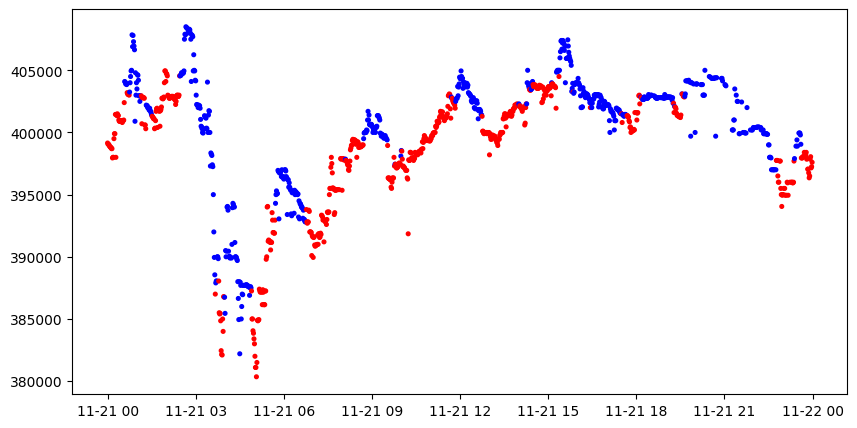

In [ ]:
# 시각화
sub_data = modify_data.loc['2017-11-21', 'close']
c_sig = label['bin'].loc['2017-11-21']
c_sig['color'] = np.where(c_sig == 1, 'red', 'blue')

fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.scatter(sub_data.index, sub_data.values, c=c_sig['color'], s=7)
plt.show()

In [113]:
label.loc['2017-11-21 05',:].head(10)

,t1,t_val,bin
time,,,
2017-11-21 05:00:00,2017-11-21 05:58:00,23.568619,1
2017-11-21 05:01:00,2017-11-21 05:59:00,23.110657,1
2017-11-21 05:02:00,2017-11-21 06:00:00,22.353419,1
2017-11-21 05:03:00,2017-11-21 06:01:00,21.795183,1
2017-11-21 05:04:00,2017-11-21 06:02:00,21.59683,1
2017-11-21 05:05:00,2017-11-21 06:03:00,21.963494,1
2017-11-21 05:06:00,2017-11-21 06:04:00,22.018829,1
2017-11-21 05:07:00,2017-11-21 06:05:00,21.231894,1
2017-11-21 05:08:00,2017-11-21 06:06:00,20.436047,1


## Features Engineering

[TA](https://libraries.io/pypi/ta)

In [114]:
import datetime # 날짜와 시간을 다루는 기능을 제공하는 표준 라이브러리 (예: 날짜 계산, 시간 형식 변환 등)
import sys      # 파이썬 인터프리터와 상호작용하는 기능을 제공하는 표준 라이브러리 (예: 시스템 경로 접근, 종료 등)
import os       # 운영체제와 상호작용하는 기능을 제공하는 표준 라이브러리 (예: 파일 및 디렉토리 관리, 환경 변수 접근 등)
import re       # 정규 표현식(regular expression) 작업을 위한 표준 라이브러리 (문자열 패턴 검색, 치환 등)
import io       # 스트림(stream) 기반으로 데이터를 다루는 기능을 제공하는 표준 라이브러리 (메모리 내 파일처럼 다루기 등)
import json     # JSON(JavaScript Object Notation) 데이터를 인코딩/디코딩하는 기능을 제공하는 표준 라이브러리

import numpy as np    
import pandas as pd   
import matplotlib.pyplot as plt 

import ta             # 기술적 분석 지표를 계산하는 데 특화된 라이브러리 (이동평균, RSI, 볼린저 밴드 등)
import shap           # SHAP (SHapley Additive exPlanations) 라이브러리, 머신러닝 모델의 예측 결과를 해석하는 데 사용

from sklearn.feature_selection import SequentialFeatureSelector, RFECV # 특성 선택 관련
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, VotingClassifier

In [115]:
# 데이터 불러오기
DATA_PATH = '/Users/kwonkyoungmi/workspaces/workspace_Python/data/TS/'
anno_file_name = os.path.join(DATA_PATH, 'sub_upbit_eth_min_tick_label.pkl')
target_file_name = os.path.join(DATA_PATH, 'sub_upbit_eth_min_tick.csv')

df_modify_data = pd.read_csv(target_file_name, index_col=0, parse_dates=True)
df_label_data = pd.read_pickle(anno_file_name)
df_sub_modify_data = df_modify_data.loc[df_label_data.index]

# 학습 시간 단축을 위해 여기선 편의상 1000개의 데이터만 가져옵니다.
df_sub_modify_data = df_sub_modify_data.iloc[:1000]

In [20]:
df_sub_modify_data.head()

,open,high,low,close,volume
time,,,,,
2018-01-01 00:00:00,1028000,1028000,1026500,1028000,41.835689
2018-01-01 00:01:00,1028000,1029000,1026000,1028500,22.307810
2018-01-01 00:02:00,1028000,1029000,1028000,1028000,59.276102
2018-01-01 00:03:00,1028000,1028000,1014000,1014000,114.203740
2018-01-01 00:04:00,1020000,1027000,1014500,1025000,62.695404


In [22]:
df_label_data.head(), df_label_data.tail()

(time
 2018-01-01 00:00:00   -0.0
 2018-01-01 00:01:00   -0.0
 2018-01-01 00:02:00   -0.0
 2018-01-01 00:03:00   -1.0
 2018-01-01 00:04:00   -1.0
 Name: t_value, dtype: float64,
 time
 2019-11-03 10:29:00   NaN
 2019-11-03 10:30:00   NaN
 2019-11-03 10:31:00   NaN
 2019-11-03 10:32:00   NaN
 2019-11-03 10:33:00   NaN
 Name: t_value, dtype: float64)

In [23]:
df_label_data.value_counts()

t_value
-1.0    306636
-0.0    302963
 1.0    299289
Name: count, dtype: int64

## Technical Index 적용하기

#### 기술적 지표
시장의 주가 또는 거래량 데이터를 기반으로 주가의 향방을 예측하기 위해 고안된 지표

In [24]:
## 금융시계열데이터(df_)에 거래량, 변동성, 모멘텀과 같은 다양한 기술적 분석 지표들을 추가

mt = 1          # multiply factor for window size
fillna = False  # Null 값 처리 여부
df_ = df_sub_modify_data.copy()
# 컬럼 이름을 변수로 정의하여 가독성을 높이고 오타를 방지
open, high, low, close, volume = 'open', 'high', 'low', 'close', 'volume'
cols = [open, high, low, close, volume]

## Volume Index(거래량지표)----------------------------
# 거래량 지표는 가격 움직임에 대한 거래량의 강도를 측정하여,
# 가격 변동의 신뢰성과 추세의 지속 가능성을 판단하는 데 사용

# Chaikin Money Flow
# 매수/매도 압력을 측정하는 지표. 거래량이 가격의 상승/하락과 함께 움직이는지 확인
# 윈도우: 20*mt (20일/기간)
df_["volume_cmf"] = ta.volume.ChaikinMoneyFlowIndicator(
                        high=df_[high], low=df_[low], close=df_[close], volume=df_[volume], window=20*mt, fillna=fillna
                    ).chaikin_money_flow()

# Force Index
# 가격 변화와 거래량을 결합하여 '가격 움직임의 강도'를 측정하는 지표
# 윈도우: 15*mt (15일/기간)
df_["volume_fi"] = ta.volume.ForceIndexIndicator(
                        close=df_[close], volume=df_[volume], window=15*mt, fillna=fillna
                    ).force_index()

# Money Flow Indicator
# 과매수/과매도 수준을 나타내는 모멘텀 오실레이터로, 가격과 거래량을 모두 고려하여 '자금의 유입/유출을 측정'
# 윈도우: 15*mt (15일/기간)
df_["volume_mfi"] = ta.volume.MFIIndicator(
                        high=df_[high],
                        low=df_[low],
                        close=df_[close],
                        volume=df_[volume],
                        window=15*mt,
                        fillna=fillna,
                    ).money_flow_index()
# Ease of Movement / Simple Moving Average of Ease of Movement (SMA_EM)
# 가격이 움직이는 데 필요한 거래량의 용이성을 측정. 적은 거래량으로 가격이 크게 움직이면 높은 EMV.
# 윈도우: 15*mt (15일/기간)
df_["volume_sma_em"] = ta.volume.EaseOfMovementIndicator(
                            high=df_[high], low=df_[low], volume=df_[volume], window=15*mt, fillna=fillna
                        ).sma_ease_of_movement()


# Volume Price Trend
# 거래량을 가격 변화율에 가중치를 주어 누적하여, 자금 흐름과 가격 추세의 관계를 측정.
df_["volume_vpt"] = ta.volume.VolumePriceTrendIndicator(
                        close=df_[close], volume=df_[volume], fillna=fillna
                    ).volume_price_trend()

## volatility index(변동성지표) ------------
# 변동성 지표는 가격이 얼마나 빠르게 또는 크게 변동하는지를 측정하여,
# 시장의 위험 수준이나 잠재적인 가격 움직임의 폭을 판단하는 데 사용

# Average True Range
# 일정 기간 동안의 평균적인 가격 변동폭을 측정. 시장의 변동성을 나타내며, 추세의 강도나 정지 지점을 설정하는 데 사용.
# 윈도우: 10*mt (10일/기간)
df_["volatility_atr"] = ta.volatility.AverageTrueRange(
                            close=df_[close], high=df_[high], low=df_[low], window=10*mt, fillna=fillna
                        ).average_true_range()

# Ulcer Index
# 투자자의 손실 위험(drawdown)과 관련된 지표. 가격이 최고점에서 얼마나 하락했는지, 얼마나 오랫동안 그 상태가 지속되었는지를 측정.
# 윈도우: 15*mt (15일/기간)
df_["volatility_ui"] = ta.volatility.UlcerIndex(
                            close=df_[close], window=15*mt, fillna=fillna
                        ).ulcer_index()

## trend index
# 추세 지표는 가격 움직임의 방향과 강도를 파악하여,
# 현재 시장이 상승 추세인지, 하락 추세인지, 혹은 횡보 추세인지를 판단하는 데 사용됩니다.

# MACD (Moving Average Convergence Divergence) MACD-히스토그램
# 서로 다른 두 이동평균선(단기, 장기)의 차이를 이용해 추세의 강도, 방향, 모멘텀 변화를 파악.
# macd_diff는 MACD선과 시그널선(MACD선의 이동평균)의 차이를 나타내는 MACD 히스토그램.
# window_slow: 25*mt, window_fast: 10*mt, window_sign: 9 (시그널 선의 윈도우)
df_["trend_macd_diff"] = ta.trend.MACD(
                            close=df_[close], window_slow=25*mt, window_fast=10*mt, window_sign=9, fillna=fillna
                        ).macd_diff()

# Average Directional Movement Index (ADX)
# 추세의 존재 여부와 강도를 측정하는 지표. ADX 값이 높을수록 추세가 강함을 의미.
# 윈도우: 15*mt (15일/기간)
df_["trend_adx"] = ta.trend.ADXIndicator(
                        high=df_[high], low=df_[low], close=df_[close], window=15*mt, fillna=fillna
                    ).adx()

# TRIX Indicator
# 삼중 지수 이동평균의 변화율을 측정하여 추세의 방향과 모멘텀을 나타냄.
# 윈도우: 15*mt (15일/기간)
df_["trend_trix"] = ta.trend.TRIXIndicator(
                        close=df_[close], window=15*mt, fillna=fillna
                    ).trix()

# Mass Index
# 고가와 저가의 범위 폭(일일 등락폭)의 이동평균을 측정하여 추세 반전을 예측.
# 특히, 지표가 특정 수준 이상으로 상승하면 추세 전환을 암시할 수 있음.
# window_fast: 10*mt, window_slow: 25*mt
df_["trend_mass_index"] = ta.trend.MassIndex(
                            high=df_[high], low=df_[low], window_fast=10*mt, window_slow=25*mt, fillna=fillna
                        ).mass_index()

# DPO Indicator (Detrended Price Oscillator)
# 이동평균을 제거하여 가격의 추세를 제거하고, 가격의 고점/저점 사이클을 측정.
# 윈도우: 20*mt (20일/기간)
df_["trend_dpo"] = ta.trend.DPOIndicator(
                        close=df_[close], window=20*mt, fillna=fillna
                    ).dpo()

# Aroon Indicator
# 특정 기간 동안 최고가와 최저가가 얼마나 최근에 발생했는지를 측정하여 추세의 강도와 잠재적 반전 지점을 파악.
# Aroon Up(상승)과 Aroon Down(하락) 라인으로 구성되며, aroon_indicator()는 일반적으로 두 라인의 차이 또는 둘 다를 반환.
# 윈도우: 20 (별도의 mt 미적용)
df_["trend_aroon_ind"] = ta.trend.AroonIndicator(close=df_[close], window=20, fillna=fillna).aroon_indicator()

## momentum index (모멘텀지표) --------------
# 모멘텀 지표는 가격 움직임의 속도와 강도를 측정
# 현재 추세가 얼마나 강력하게 지속될 것인지, 또는 과매수/과매도 상태인지를 판단하는 데 사용

# Relative Strength Index (RSI)
# 일정 기간 동안의 평균 상승 폭과 평균 하락 폭을 비교하여 가격 변동의 강도를 0~100 사이의 값으로 나타냄.
# 과매수(70 이상) 및 과매도(30 이하) 수준을 파악하여 추세 전환 신호로 활용.
# 윈도우: 15*mt (15일/기간)
df_["momentum_rsi"] = ta.momentum.RSIIndicator(close=df_[close], window=15*mt, fillna=fillna).rsi()

# Williams R Indicator
# Williams R Indicator (Williams %R)
# 특정 기간 동안 현재 종가가 최고가와 최저가 범위 내에서 어디에 위치하는지를 나타내는 모멘텀 오실레이터.
# 과매수(보통 -20 이상) 및 과매도(보통 -80 이하) 수준을 판단.
# lbp (LookBack Period): 15*mt (15일/기간)
df_["momentum_wr"] = ta.momentum.WilliamsRIndicator(
                        high=df_[high], low=df_[low], close=df_[close], lbp=15*mt, fillna=fillna
                    ).williams_r()

In [25]:
# 결과확인
df_.head()

,open,high,low,close,volume,volume_cmf,volume_fi,volume_mfi,volume_sma_em,volume_vpt,volatility_atr,volatility_ui,trend_macd_diff,trend_adx,trend_trix,trend_mass_index,trend_dpo,trend_aroon_ind,momentum_rsi,momentum_wr
time,,,,,,,,,,,,,,,,,,,,
2018-01-01 00:00:00,1028000,1028000,1026500,1028000,41.835689,NaN,NaN,NaN,NaN,-0.796083,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-01 00:01:00,1028000,1029000,1026000,1028500,22.307810,NaN,NaN,NaN,NaN,-0.788285,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-01 00:02:00,1028000,1029000,1028000,1028000,59.276102,NaN,NaN,NaN,NaN,-0.017967,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-01 00:03:00,1028000,1028000,1014000,1014000,114.203740,NaN,NaN,NaN,NaN,-1.584121,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-01 00:04:00,1020000,1027000,1014500,1025000,62.695404,NaN,NaN,NaN,NaN,-0.875176,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN


#### 수익률 / 변동성 지표

In [26]:
windows_mom = [5, 10, 20]  # 모멘텀 지표 계산에 사용할 윈도우(기간)
windows_std = [30] # 표준편차(변동성) 지표 계산에 사용할 윈도우(기간)


# windows_mom에 설정된 각 기간(i)에 대해 반복
for i in windows_mom:
    # 거래량 변화율
    df_[f'vol_change_{i}'] = df_.volume.pct_change(i).round(6) # 현재 거래량과 i 기간 전 거래량의 변화율을 계산
    # 종가 수익률
    df_[f'ret_{i}'] = df_.close.pct_change(i).round(6)

for i in windows_std:
    # 종가 표준편차
    df_[f'std_{i}'] = df_.close.rolling(i).std()
    # 거래량 표준편차
    df_[f'vol_std_{i}'] = df_.volume.rolling(i).std()

In [27]:
# 결과 확인
df_.head(10)

,open,high,low,close,volume,volume_cmf,volume_fi,volume_mfi,volume_sma_em,volume_vpt,...,momentum_rsi,momentum_wr,vol_change_5,ret_5,vol_change_10,ret_10,vol_change_20,ret_20,std_30,vol_std_30
time,,,,,,,,,,,,,,,,,,,,,
2018-01-01 00:00:00,1028000,1028000,1026500,1028000,41.835689,NaN,NaN,NaN,NaN,-0.796083,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-01 00:01:00,1028000,1029000,1026000,1028500,22.307810,NaN,NaN,NaN,NaN,-0.788285,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-01 00:02:00,1028000,1029000,1028000,1028000,59.276102,NaN,NaN,NaN,NaN,-0.017967,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-01 00:03:00,1028000,1028000,1014000,1014000,114.203740,NaN,NaN,NaN,NaN,-1.584121,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-01 00:04:00,1020000,1027000,1014500,1025000,62.695404,NaN,NaN,NaN,NaN,-0.875176,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-01 00:05:00,1015000,1025500,1014500,1015500,80.181375,NaN,NaN,NaN,NaN,-0.063017,...,NaN,NaN,0.916578,-0.012160,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-01 00:06:00,1015500,1018000,1015500,1018000,4.568057,NaN,NaN,NaN,NaN,-0.731899,...,NaN,NaN,-0.795226,-0.010209,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-01 00:07:00,1018500,1021500,1018000,1018000,43.054871,NaN,NaN,NaN,NaN,0.011246,...,NaN,NaN,-0.273655,-0.009728,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-01 00:08:00,1018000,1020000,1015000,1017000,97.388341,NaN,NaN,NaN,NaN,-0.095666,...,NaN,NaN,-0.147240,0.002959,NaN,NaN,NaN,NaN,NaN,NaN


In [28]:
df_tmp_data = df_.join(df_label_data).dropna()
X, y = df_tmp_data.iloc[:, 5:-1], df_tmp_data.iloc[:, -1]

In [29]:
X.head(2)

,volume_cmf,volume_fi,volume_mfi,volume_sma_em,volume_vpt,volatility_atr,volatility_ui,trend_macd_diff,trend_adx,trend_trix,...,momentum_rsi,momentum_wr,vol_change_5,ret_5,vol_change_10,ret_10,vol_change_20,ret_20,std_30,vol_std_30
time,,,,,,,,,,,,,,,,,,,,,
2018-01-01 00:43:00,0.363435,719.550725,56.072055,8.940793e+11,0.036253,3465.281623,0.373803,57.922971,30.265684,0.001918,...,50.582791,-42.105263,-0.678913,0.000000,-0.318982,0.00000,-0.818597,0.004438,2348.63619,34.165561
2018-01-01 00:44:00,0.368141,10053.792799,54.776628,2.480511e+12,0.103776,3468.753461,0.363350,371.772328,28.931595,0.002456,...,55.496761,-10.526316,-0.294524,0.007396,-0.266406,0.00049,-0.363379,0.006404,2465.21781,34.384398


In [30]:
y.head(2)

time
2018-01-01 00:43:00    1.0
2018-01-01 00:44:00    1.0
Name: t_value, dtype: float64

## Feature Selection methods

① Feature Selection     
- MDI       
- MDA       

② Sequential Feature Selection      
- RFE CV        
- SFS       

③ Shapley Additive explanations     
- SHAP      

In [31]:
from sklearn.model_selection import KFold
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, VotingClassifier

In [32]:
sc = StandardScaler()
X_sc = sc.fit_transform(X)
X_sc = pd.DataFrame(X_sc, index=X.index, columns=X.columns)

In [33]:
X_sc.head(2)

,volume_cmf,volume_fi,volume_mfi,volume_sma_em,volume_vpt,volatility_atr,volatility_ui,trend_macd_diff,trend_adx,trend_trix,...,momentum_rsi,momentum_wr,vol_change_5,ret_5,vol_change_10,ret_10,vol_change_20,ret_20,std_30,vol_std_30
time,,,,,,,,,,,,,,,,,,,,,
2018-01-01 00:43:00,1.035464,-0.186753,0.065427,0.391695,0.143181,1.474065,0.054076,0.103695,0.930692,-0.078062,...,-0.141586,0.073599,-0.268825,-0.053926,-0.273922,-0.077989,-0.359687,0.617241,-0.335632,0.273404
2018-01-01 00:44:00,1.054026,0.125880,-0.011156,0.814123,0.544363,1.478520,0.017250,0.639945,0.771813,-0.051294,...,0.344922,1.111779,-0.209690,2.237163,-0.263511,0.036043,-0.266915,0.940844,-0.262646,0.291664


In [34]:
rfc = RandomForestClassifier(class_weight='balanced')
rfc.fit(X_sc, y)

RandomForestClassifier(class_weight='balanced')

#### MDI, Mean Decrease Impurity
Tree 계열 분류기에서 산출되는 Feature Importance 값을 사용한 Feature Selection 기법     
>In-Sample 방식 --> Train Set의 정확도를 기반으로 하기 때문에 In-Sample 이라고 함        
>모든 Feature가 어느 정도의 중요도를 갖음         
>모든 Feature Importance 의 총합은 1     
>substitution effect를 해결하지 못 함        

In [35]:
def mean_decrease_impurity(model, feature_names, clustered_subsets=None):
    """
    Advances in Financial Machine Learning, Snippet 8.2, page 115.
    MDI Feature importance
    Mean decrease impurity (MDI) is a fast, explanatory-importance (in-sample, IS) method specific to tree-based
    classifiers, like RF. At each node of each decision tree, the selected feature splits the subset it received in
    such a way that impurity is decreased. Therefore, we can derive for each decision tree how much of the overall
    impurity decrease can be assigned to each feature. And given that we have a forest of trees, we can average those
    values across all estimators and rank the features accordingly.
    Tip:
    Masking effects take place when some features are systematically ignored by tree-based classifiers in favor of
    others. In order to avoid them, set max_features=int(1) when using sklearn’s RF class. In this way, only one random
    feature is considered per level.
    Notes:
    * MDI cannot be generalized to other non-tree based classifiers
    * The procedure is obviously in-sample.
    * Every feature will have some importance, even if they have no predictive power whatsoever.
    * MDI has the nice property that feature importances add up to 1, and every feature importance is bounded between 0 and 1.
    * method does not address substitution effects in the presence of correlated features. MDI dilutes the importance of
      substitute features, because of their interchangeability: The importance of two identical features will be halved,
      as they are randomly chosen with equal probability.
    * Sklearn’s RandomForest class implements MDI as the default feature importance score. This choice is likely
      motivated by the ability to compute MDI on the fly, with minimum computational cost.
    Clustered Feature Importance( Machine Learning for Asset Manager snippet 6.4 page 86) :
    Clustered MDI  is the  modified version of MDI (Mean Decreased Impurity). It  is robust to substitution effect that
    takes place when two or more explanatory variables share a substantial amount of information (predictive power).CFI
    algorithm described by Dr Marcos Lopez de Prado  in Clustered Feature  Importance section of book Machine Learning
    for Asset Manager. Here  instead of  taking the importance  of  every feature, we consider the importance of every
    feature subsets, thus every feature receive the importance of subset it belongs to.
    :param model: (model object): Trained tree based classifier.
    :param feature_names: (list): Array of feature names.
    :param clustered_subsets: (list) Feature clusters for Clustered Feature Importance (CFI). Default None will not apply CFI.
                              Structure of the input must be a list of list/s i.e. a list containing the clusters/subsets of feature
                              name/s inside a list. E.g- [['I_0','I_1','R_0','R_1'],['N_1','N_2'],['R_3']]
    :return: (pd.DataFrame): Mean and standard deviation feature importance.
    """
    # Feature importance based on in-sample (IS) mean impurity reduction
    feature_imp_df = {i: tree.feature_importances_ for i, tree in enumerate(model.estimators_)}
    feature_imp_df = pd.DataFrame.from_dict(feature_imp_df, orient='index')
    feature_imp_df.columns = feature_names

    # Make sure that features with zero importance are not averaged, since the only reason for a 0 is that the feature
    # was not randomly chosen. Replace those values with np.nan
    feature_imp_df = feature_imp_df.replace(0, np.nan)  # Because max_features = 1

    if clustered_subsets is not None:
        # Getting subset wise importance
        importance = pd.DataFrame(index=feature_names, columns=['mean', 'std'])
        for subset in clustered_subsets: # Iterating over each cluster
            subset_feat_imp = feature_imp_df[subset].sum(axis=1)
            # Importance of each feature within a subsets is equal to the importance of that subset
            importance.loc[subset, 'mean'] = subset_feat_imp.mean()
            importance.loc[subset, 'std'] = subset_feat_imp.std()*subset_feat_imp.shape[0]**-.5
    else:
        importance = pd.concat({'mean': feature_imp_df.mean(),
                                'std': feature_imp_df.std() * feature_imp_df.shape[0] ** -0.5},
                               axis=1)

    importance /= importance['mean'].sum()
    return importance


In [36]:
feat_imp = mean_decrease_impurity(rfc, X.columns)
feat_imp

,mean,std
volume_cmf,0.045912,0.002170
volume_fi,0.046492,0.002230
volume_mfi,0.048894,0.002336
volume_sma_em,0.037269,0.001866
volume_vpt,0.025050,0.001726
volatility_atr,0.083076,0.003270
volatility_ui,0.052147,0.002897
trend_macd_diff,0.076881,0.004107
trend_adx,0.056350,0.002520
trend_trix,0.064206,0.002790


#### MDA, Mean Decrease Accuracy

Tree 외의의 분류기에서도 사용가능한 Feature Selection 기법      
>OOS(Out-of-Sample) 방식 --> Test Set을 기준으로 정확도를 산출하는 방식이기 때문에 OOS 라고 칭함         
>Accuracy 이외의 다른 성능지표를 사용할 수 있음          
>MDI와 마차가지로 substitution effect에서 자유롭지 못 함     
>MDI와 달리, 모든 Feature가 중요하다고 나오지 않을 수 있음       
>연산 절차
>>분류기를 Fitting      
>>성능지표에 따라 OOS 성능을 측정       
>>순차적으로 각 feature에 대해서, 무작위로 섞은 후 OOS 성능을 기존값과 비교하는 작업을 전체 Feature에 대해 수행     

In [37]:

def mean_decrease_accuracy(model, X, y, cv_gen, clustered_subsets=None, sample_weight_train=None,
                           sample_weight_score=None, scoring=log_loss, random_state=42):
    """
    Advances in Financial Machine Learning, Snippet 8.3, page 116-117.
    MDA Feature Importance
    Mean decrease accuracy (MDA) is a slow, predictive-importance (out-of-sample, OOS) method. First, it fits a
    classifier; second, it derives its performance OOS according to some performance score (accuracy, negative log-loss,
    etc.); third, it permutates each column of the features matrix (X), one column at a time, deriving the performance
    OOS after each column’s permutation. The importance of a feature is a function of the loss in performance caused by
    its column’s permutation. Some relevant considerations include:
    * This method can be applied to any classifier, not only tree-based classifiers.
    * MDA is not limited to accuracy as the sole performance score. For example, in the context of meta-labeling
      applications, we may prefer to score a classifier with F1 rather than accuracy. That is one reason a better
      descriptive name would have been “permutation importance.” When the scoring function does not correspond to a
      metric space, MDA results should be used as a ranking.
    * Like MDI, the procedure is also susceptible to substitution effects in the presence of correlated features.
      Given two identical features, MDA always considers one to be redundant to the other. Unfortunately, MDA will make
      both features appear to be outright irrelevant, even if they are critical.
    * Unlike MDI, it is possible that MDA concludes that all features are unimportant. That is because MDA is based on
      OOS performance.
    * The CV must be purged and embargoed.
    Clustered Feature Importance( Machine Learning for Asset Manager snippet 6.5 page 87) :
    Clustered MDA is the modified version of MDA (Mean Decreased Accuracy). It is robust to substitution effect that takes
    place when two or more explanatory variables share a substantial amount of information (predictive power).CFI algorithm
    described by Dr Marcos Lopez de Prado  in Clustered Feature  Importance (Presentation Slides)
    https://papers.ssrn.com/sol3/papers.cfm?abstract_id=3517595. Instead of shuffling (permutating) all variables
    individually (like in MDA), we shuffle all variables in cluster together. Next, we follow all the  rest of the
    steps as in MDA. It can used by simply specifying the clustered_subsets argument.
    :param model: (sklearn.Classifier): Any sklearn classifier.
    :param X: (pd.DataFrame): Train set features.
    :param y: (pd.DataFrame, np.array): Train set labels.
    :param cv_gen: (cross_validation.PurgedKFold): Cross-validation object.
    :param clustered_subsets: (list) Feature clusters for Clustered Feature Importance (CFI). Default None will not apply CFI.
                              Structure of the input must be a list of list/s i.e. a list containing the clusters/subsets of feature
                              name/s inside a list. E.g- [['I_0','I_1','R_0','R_1'],['N_1','N_2'],['R_3']]
    :param sample_weight_train: (np.array) Sample weights used to train the model for each record in the dataset.
    :param sample_weight_score: (np.array) Sample weights used to evaluate the model quality.
    :param scoring: (function): Scoring function used to determine importance.
    :param random_state: (int) Random seed for shuffling the features.
    :return: (pd.DataFrame): Mean and standard deviation of feature importance.
    """

    if sample_weight_train is None:
        sample_weight_train = np.ones((X.shape[0],))

    if sample_weight_score is None:
        sample_weight_score = np.ones((X.shape[0],))

    fold_metrics_values, features_metrics_values = pd.Series(dtype='float64'), pd.DataFrame(columns=X.columns)
    # Generating a numpy random state object for the given random_state
    rs_obj = np.random.RandomState(seed=random_state)
    # Clustered feature subsets will be used for CFI if clustered_subsets exists else will operate on the single column as MDA
    feature_sets = clustered_subsets if clustered_subsets else [[x] for x in X.columns]
    for i, (train, test) in enumerate(cv_gen.split(X=X)):
        fit = model.fit(X=X.iloc[train, :], y=y.iloc[train], sample_weight=sample_weight_train[train])
        pred = fit.predict(X.iloc[test, :])

        # Get overall metrics value on out-of-sample fold
        if scoring == log_loss:
            prob = fit.predict_proba(X.iloc[test, :])
            fold_metrics_values.loc[i] = -scoring(y.iloc[test], prob, sample_weight=sample_weight_score[test],
                                                  labels=model.classes_)
        else:
            fold_metrics_values.loc[i] = scoring(y.iloc[test], pred, sample_weight=sample_weight_score[test])

        # Get feature specific metric on out-of-sample fold
        for j in feature_sets:
            X1_ = X.iloc[test, :].copy(deep=True)
            for j_i in j:
                rs_obj.shuffle(X1_[j_i].values)  # Permutation of a single column for MDA or through the whole subset for CFI
            if scoring == log_loss:
                prob = fit.predict_proba(X1_)
                features_metrics_values.loc[i, j] = -scoring(y.iloc[test], prob,
                                                             sample_weight=sample_weight_score[test],
                                                             labels=model.classes_)
            else:
                pred = fit.predict(X1_)
                features_metrics_values.loc[i, j] = scoring(y.iloc[test], pred,
                                                            sample_weight=sample_weight_score[test])

    importance = (-features_metrics_values).add(fold_metrics_values, axis=0)
    if scoring == log_loss:
        importance = importance / -features_metrics_values
    else:
        importance = importance / (1.0 - features_metrics_values).replace(0, np.nan)
    importance = pd.concat({'mean': importance.mean(), 'std': importance.std() * importance.shape[0] ** -.5}, axis=1)
    importance.replace([-np.inf, np.nan], 0, inplace=True)  # Replace infinite values

    return importance

In [38]:
svc_rbf = SVC(kernel='rbf', probability=True)
cv = KFold(n_splits=5)
feat_imp_mda = mean_decrease_accuracy(svc_rbf, X_sc, y, cv_gen=cv)

In [ ]:
def plot_feature_importance(importance_df, save_fig=False, output_path=None):
    # Plot mean imp bars with std
    plt.figure(figsize=(10, importance_df.shape[0] / 5))
    importance_df.sort_values('mean', ascending=True, inplace=True)
    importance_df['mean'].plot(kind='barh', color='b', alpha=0.25, xerr=importance_df['std'], error_kw={'ecolor': 'r'})
    # xerr=importance_df['std']: 각 막대에 오차 막대(error bar)를 추가 / 막대의 길이는 'importance_df'의 'std' 컬럼(특성 중요도의 표준 편차) 값에 따라 결정
    # 오차 막대는 특성 중요도의 일관성, 편차의 크기 나타냄
    # error_kw={'ecolor': 'r'}: 오차 막대의 색상을 빨간색(red)으로 설정

    if save_fig: # 그래프를 파일로 저장할지(True) 아니면 화면에 바로 보여줄지(False)를 제어
        plt.savefig(output_path)
    else:
        plt.show()

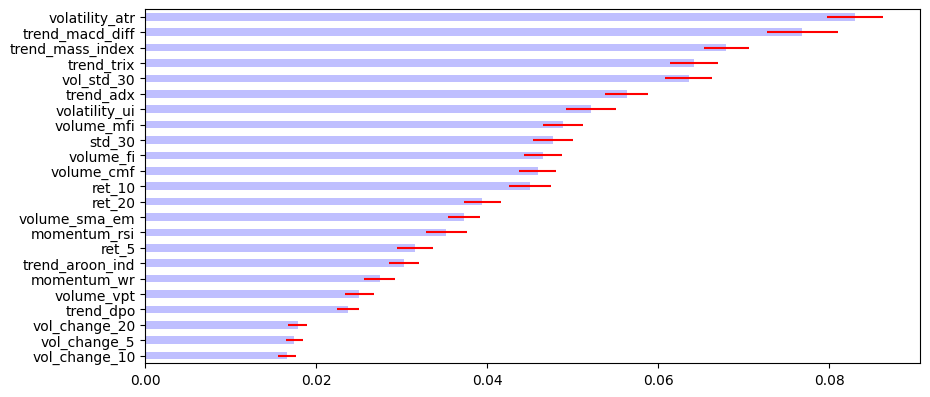

In [ ]:
# MDI 시각화
plot_feature_importance(feat_imp)

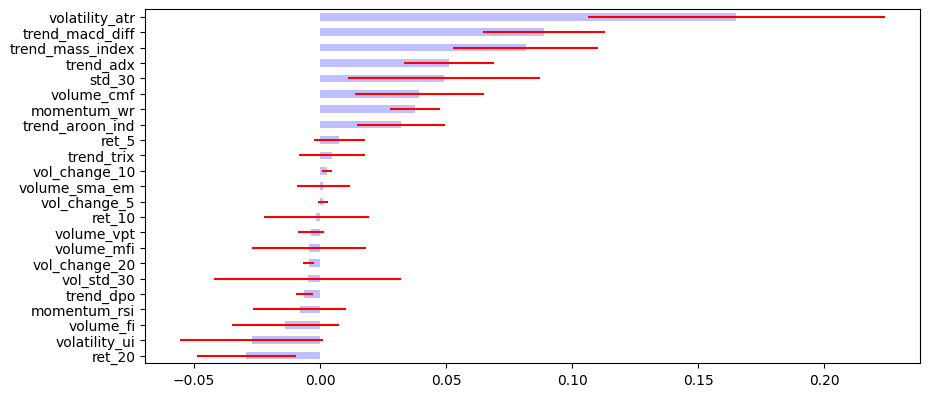

In [ ]:
# MDA 시각화
plot_feature_importance(feat_imp_mda)

### RFE CV
RFE방식에 CV를 도입한 기법      
Data Set을 K개로 분할하여 학습과 검증을 동시에 진행하며, 검증시 Feature의 기여도에 따라 삭제 여부를 결정하는 방식       
Validation 성능이 가장 좋은 Feature를 최종 Feature로 결정

In [ ]:
# Recursive Feature Elimination with Cross-Validation (RFECV)

from sklearn.model_selection import KFold
from sklearn.svm import SVC
from sklearn.feature_selection import RFECV
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
X_sc = sc.fit_transform(X)
X_sc = pd.DataFrame(X_sc, index=X.index, columns=X.columns)

cv = KFold(n_splits=5)
svc_linear = SVC(kernel='linear', probability=True) # kernel='linear' : 선형 커널을 사용해야 함 주의! (rbf 커널은 RFECV에서 지원하지 않음)
rfe_cv = RFECV(svc_linear, cv=cv) # Recursive Feature Elimination with Cross-Validation # RFECV는 교차 검증을 통해 최적의 특성 개수를 찾는 방법

rfe_fitted = rfe_cv.fit(X_sc, y) # rfe_cv.fit(X_sc, y)  # RFECV를 사용하여 특성 선택 및 모델 학습

In [43]:
rfe_fitted.support_ # 선택된 특성의 불리언 마스크 반환 (True는 선택된 특성, False는 선택되지 않은 특성)

array([False, False, False, False, False,  True, False,  True, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False,  True, False])

In [44]:
rfe_fitted.ranking_ # 각 특성의 순위 반환 (1이 가장 중요한 특성)

array([12,  4, 14,  7,  8,  1, 11,  1, 19, 10, 13, 16,  5,  2,  3, 20, 18,
       21, 17, 15,  6,  1,  9])

In [ ]:
# 선택된 피쳐 확인하기
rfe_df = pd.DataFrame([rfe_fitted.support_, rfe_fitted.ranking_], columns=X_sc.columns).T.rename(columns={0:"Optimal_Features", 1:"Ranking"})
rfe_df

,Optimal_Features,Ranking
volume_cmf,False,12
volume_fi,False,4
volume_mfi,False,14
volume_sma_em,False,7
volume_vpt,False,8
volatility_atr,True,1
volatility_ui,False,11
trend_macd_diff,True,1
trend_adx,False,19
trend_trix,False,10


In [46]:
rfe_df[rfe_df["Optimal_Features"]==True]

,Optimal_Features,Ranking
volatility_atr,True,1
trend_macd_diff,True,1
std_30,True,1


### SFS
순차적으로 Feature를 더하거나 빼는 방식으로 Feature의 최적조합을 찾는 방식           
>Backward / Forward 방식 모두 사용할 수 있음            
>>Forward: Null에서 시작하여, Feature를 하나씩 더해가는 방식으로 조합을 찾음         
>>Backwrd: 모든 Feature에서 시작하여 하나씩 빼가는 방식으로 조합을 찾음          

In [47]:
from sklearn.feature_selection import SequentialFeatureSelector # 특성 선택 관련
from sklearn.model_selection import KFold
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler


sc = StandardScaler()
X_sc = sc.fit_transform(X)
X_sc = pd.DataFrame(X_sc, index=X.index, columns=X.columns)

cv = KFold(n_splits=5)
svc_rbf = SVC(kernel='rbf', probability=True)

n = 2

sfs_forward = SequentialFeatureSelector(svc_rbf, n_features_to_select=n, direction='forward')
sfs_fitted = sfs_forward.fit(X_sc, y)

In [53]:
sfs_fitted.get_support()  # 선택된 특성의 불리언 마스크 반환 (True는 선택된 특성, False는 선택되지 않은 특성)

array([False, False,  True, False, False, False, False,  True, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False])

In [54]:
sfs_fitted.transform(X_sc) # 선택된 특성만 포함된 데이터프레임 반환

array([[ 0.06542733,  0.10369472],
       [-0.01115595,  0.63994495],
       [ 0.06319457,  0.71413283],
       ...,
       [ 1.14110023,  0.48315802],
       [ 1.13060902,  0.40873639],
       [ 1.34457803,  0.35863045]])

In [55]:
sfs_fitted.get_feature_names_out(input_features=None) # 선택된 특성의 이름 반환

array(['volume_mfi', 'trend_macd_diff'], dtype=object)

In [56]:
sfs_fitted.get_params(deep=True)

{'cv': 5,
 'direction': 'forward',
 'estimator__C': 1.0,
 'estimator__break_ties': False,
 'estimator__cache_size': 200,
 'estimator__class_weight': None,
 'estimator__coef0': 0.0,
 'estimator__decision_function_shape': 'ovr',
 'estimator__degree': 3,
 'estimator__gamma': 'scale',
 'estimator__kernel': 'rbf',
 'estimator__max_iter': -1,
 'estimator__probability': True,
 'estimator__random_state': None,
 'estimator__shrinking': True,
 'estimator__tol': 0.001,
 'estimator__verbose': False,
 'estimator': SVC(probability=True),
 'n_features_to_select': 2,
 'n_jobs': None,
 'scoring': None,
 'tol': None}

In [57]:
sfs_rank = sfs_fitted.get_support()
sfs_df = pd.DataFrame(sfs_rank, index=X_sc.columns, columns=["Optimal_Features"])

sfs_df [sfs_df ["Optimal_Features"]==True].index

Index(['volume_mfi', 'trend_macd_diff'], dtype='object')

### SHAP, Shapley Additive explannations

게임이론적인 접근방식을 통해 분류기의 출력을 설명하기 위한 기법     
게임이론으로부터 Shapley Value를 추산하여, 이를 바탕으로 Feature를 설명     

>Shapley Value란?       
>게임이론에서 여러명의 플레이어에게 공정한 상벌을 배분하기 위한 솔루션으로써,       
>여러 플레이어의 공헌도는 서로 상이하지만, 상호간에 이득과 손실을 주고받는 상황에 적용되는 값      
>게임 내에서 각 플레이어는 최대의 성과를 얻어내기 위한 의사결정을 연쇄적으로 수행하게 되며      
>그러한 과정을 통해 얻게 된 게임의 결과에서 해당 플레이어에게 기대할 수 있는 평균적인 한계 공헌도 => Shpely Value

In [ ]:
import shap

explainer = shap.TreeExplainer(rfc, model_output="raw") # SHAP 해석기를 생성 (트리 기반 모델에 대한 SHAP 값을 계산하는 데 사용)
shap_value = explainer.shap_values(X_sc)

In [60]:
shap_value.shape # (957, 23, 3) # 957개의 샘플, 23개의 특성, 3개의 클래스

(957, 23, 3)

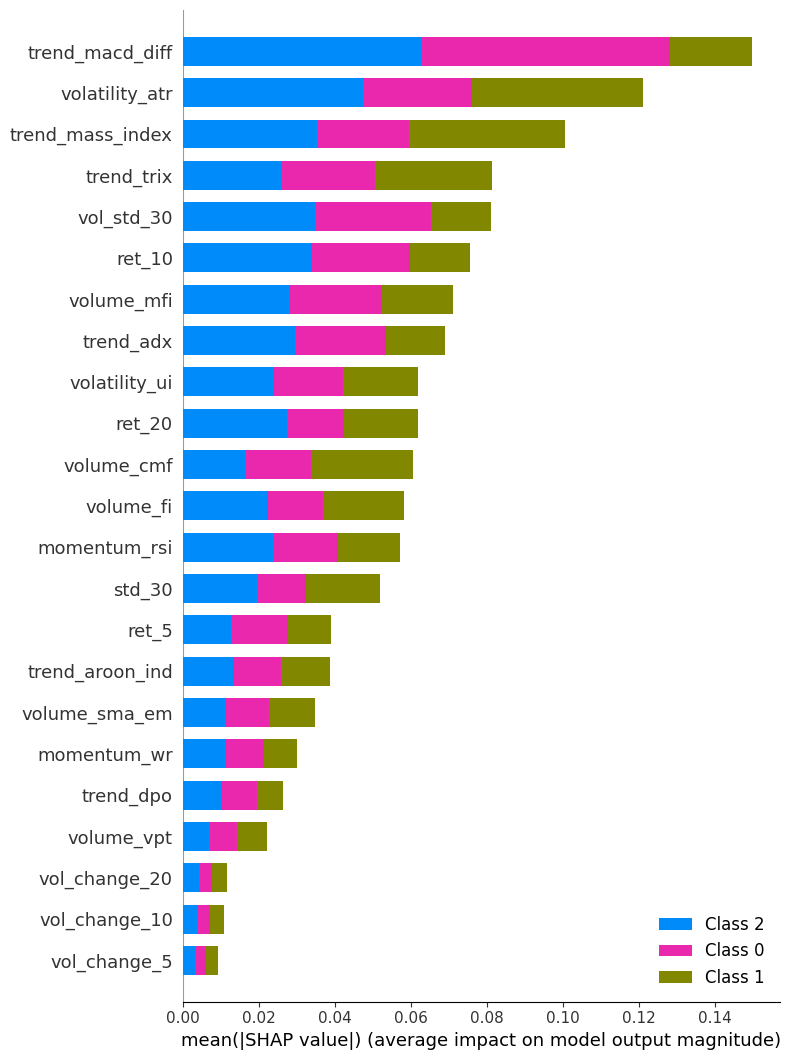

In [61]:

shap.summary_plot(shap_value, X_sc, plot_type="bar", max_display=30) # 특성 중요도 시각화

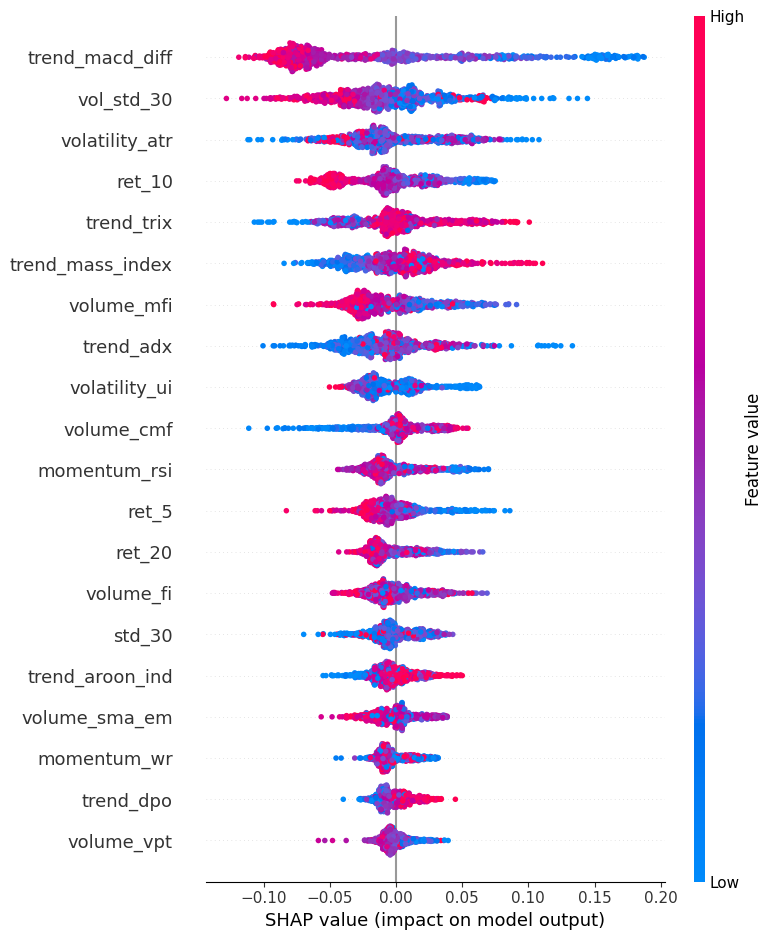

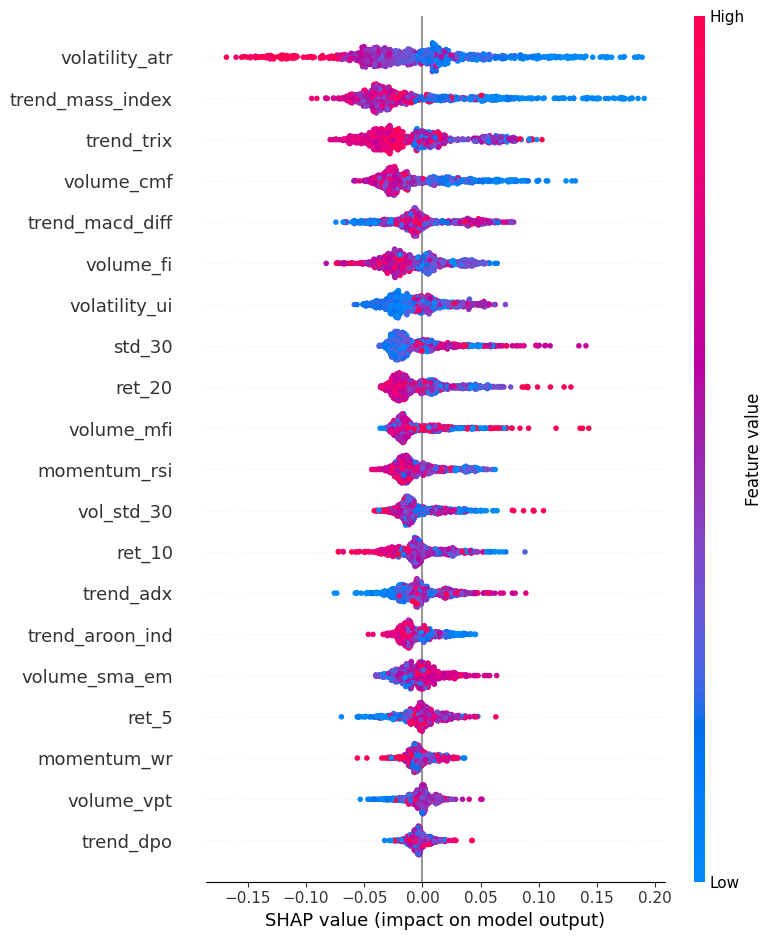

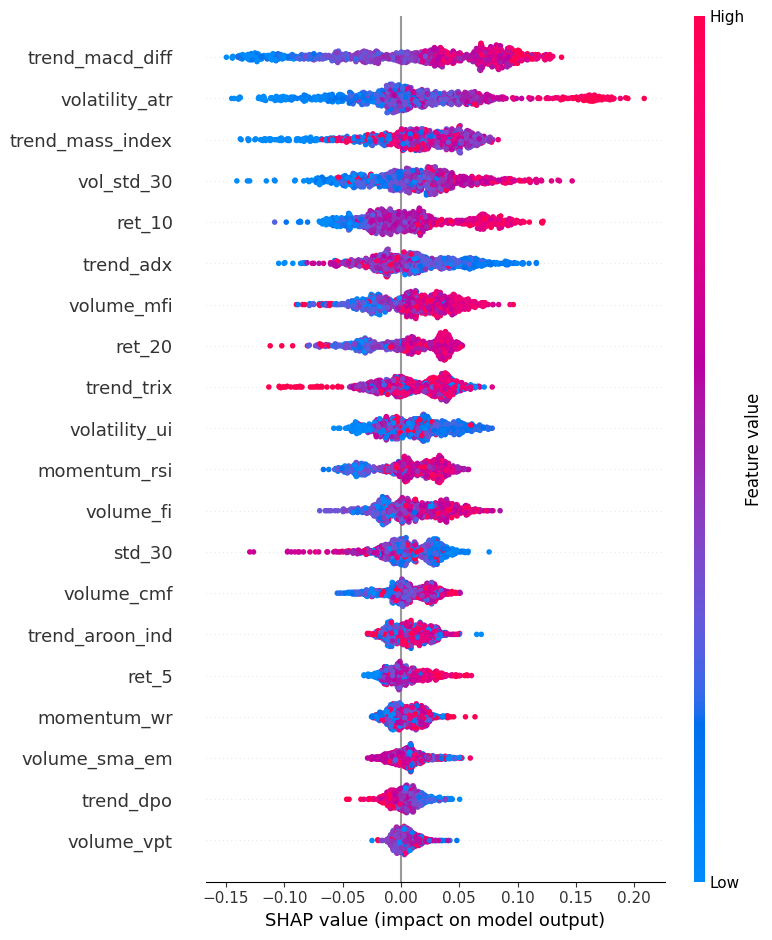

In [62]:
# 각 클래스에 대한 각각의 plot을 그려줘야함

# 클래스 0에 대한 SHAP summary plot
shap.summary_plot(shap_value[:, :, 0], X_sc, class_names='class 0')

# 클래스 1
shap.summary_plot(shap_value[:, :, 1], X_sc, class_names='class 1')

# 클래스 2
shap.summary_plot(shap_value[:, :, 2], X_sc, class_names='class 2')

In [63]:
# 절댓값 평균으로 전체 feature 중요도 요약
mean_shap = np.mean(np.abs(shap_value), axis=(0, 2))  # over samples and classes
shap_df = pd.Series(mean_shap, index=X_sc.columns).sort_values(ascending=False)
print(shap_df)

trend_macd_diff     0.049862
volatility_atr      0.040349
trend_mass_index    0.033544
trend_trix          0.027112
vol_std_30          0.027059
ret_10              0.025155
volume_mfi          0.023656
trend_adx           0.022961
volatility_ui       0.020660
ret_20              0.020614
volume_cmf          0.020200
volume_fi           0.019426
momentum_rsi        0.019075
std_30              0.017326
ret_5               0.013021
trend_aroon_ind     0.012939
volume_sma_em       0.011617
momentum_wr         0.010001
trend_dpo           0.008787
volume_vpt          0.007417
vol_change_20       0.003895
vol_change_10       0.003636
vol_change_5        0.003113
dtype: float64


In [64]:
shap.__version__

'0.47.2'

In [ ]:
## 선형모델에도 적용해 볼까?
import shap

svc_rbf = SVC(kernel='rbf', probability=True, random_state=42)
svc_rbf.fit(X_sc, y)

explainer = shap.KernelExplainer(svc_rbf.predict_proba, X_sc, shap.sample(X_sc, 100)) # KernelExplainer는 SVC와 같은 비트리 기반 모델에 사용
shap_value = explainer.shap_values(X_sc)

Using 957 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/957 [00:00<?, ?it/s]

In [68]:
output_file_name = os.path.join(DATA_PATH, 'sub_upbit_eth_min_feature_labels.pkl')
df_tmp_data.to_pickle(output_file_name)

## Model Training

In [66]:
import datetime
import sys
import os
import re
import io
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import ta

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, f1_score, roc_auc_score, roc_curve


In [70]:
output_file_name = os.path.join(DATA_PATH, 'sub_upbit_eth_min_feature_labels.pkl')
df_data = pd.read_pickle(output_file_name) 
df_data['t_value'] = df_data['t_value'].apply(lambda x: x if x == 1 else 0)

In [85]:
df_data.head(2)

,open,high,low,close,volume,volume_cmf,volume_fi,volume_mfi,volume_sma_em,volume_vpt,...,momentum_wr,vol_change_5,ret_5,vol_change_10,ret_10,vol_change_20,ret_20,std_30,vol_std_30,t_value
time,,,,,,,,,,,,,,,,,,,,,
2018-01-01 00:43:00,1017500,1019000,1017500,1018500,30.272135,0.363435,719.550725,56.072055,8.940793e+11,0.036253,...,-42.105263,-0.678913,0.000000,-0.318982,0.00000,-0.818597,0.004438,2348.63619,34.165561,1.0
2018-01-01 00:44:00,1018500,1021500,1018000,1021500,25.131162,0.368141,10053.792799,54.776628,2.480511e+12,0.103776,...,-10.526316,-0.294524,0.007396,-0.266406,0.00049,-0.363379,0.006404,2465.21781,34.384398,1.0


In [74]:
df_data['t_value'].value_counts()

t_value
1.0    481
0.0    476
Name: count, dtype: int64

In [77]:
train_ratio, test_ratio = 0.7, 0.2
n_train = int(np.round(len(df_data) * train_ratio))
n_test = int(np.round(len(df_data) * test_ratio))

In [78]:
X, y = df_data.iloc[:, 5:-1], df_data.iloc[:, -1]

In [80]:
X.head(2)

,volume_cmf,volume_fi,volume_mfi,volume_sma_em,volume_vpt,volatility_atr,volatility_ui,trend_macd_diff,trend_adx,trend_trix,...,momentum_rsi,momentum_wr,vol_change_5,ret_5,vol_change_10,ret_10,vol_change_20,ret_20,std_30,vol_std_30
time,,,,,,,,,,,,,,,,,,,,,
2018-01-01 00:43:00,0.363435,719.550725,56.072055,8.940793e+11,0.036253,3465.281623,0.373803,57.922971,30.265684,0.001918,...,50.582791,-42.105263,-0.678913,0.000000,-0.318982,0.00000,-0.818597,0.004438,2348.63619,34.165561
2018-01-01 00:44:00,0.368141,10053.792799,54.776628,2.480511e+12,0.103776,3468.753461,0.363350,371.772328,28.931595,0.002456,...,55.496761,-10.526316,-0.294524,0.007396,-0.266406,0.00049,-0.363379,0.006404,2465.21781,34.384398


In [81]:
sc = StandardScaler()
X_sc = sc.fit_transform(X)

In [82]:
train_x, test_x, train_y, test_y = X_sc[:n_train, :], X_sc[-n_test:, :], y.iloc[:n_train], y.iloc[-n_test:]

train_x = pd.DataFrame(train_x, index=train_y.index, columns=X.columns)
train_y = pd.Series(train_y, index=train_y.index)
test_x = pd.DataFrame(test_x, index=test_y.index, columns=X.columns)
test_y = pd.Series(test_y, index=test_y.index)

# 학습 시간 단축을 위해 여기선 편의상 1000개의 데이터만 가져옵니다.
train_x = train_x[:1000]
train_y = train_y[:1000]

### Purged K-fold for Cross-Validation
모든 관측값에 대해 학습데이터와 검증데이터가 서로 최대한 상관되지 않도록 시계열 집합간 일종의 시간차를 두는 방법

In [86]:
"""
Created on Fri Dec  6 19:41:30 2019

@author: sukji
"""
from typing import Callable
import pandas as pd
import numpy as np

from sklearn.metrics import log_loss
from sklearn.model_selection import KFold
from sklearn.base import ClassifierMixin
from sklearn.model_selection import BaseCrossValidator

def ml_get_train_times1(samples_info_sets: pd.Series, test_times: pd.Series) -> pd.Series:
    # pylint: disable=invalid-name
    """
    Advances in Financial Machine Learning, Snippet 7.1, page 106.

    Purging observations in the training set

    This function find the training set indexes given the information on which each record is based
    and the range for the test set.
    Given test_times, find the times of the training observations.

    :param samples_info_sets: (pd.Series) The information range on which each record is constructed from
        *samples_info_sets.index*: Time when the information extraction started.
        *samples_info_sets.value*: Time when the information extraction ended.
    :param test_times: (pd.Series) Times for the test dataset.
    :return: (pd.Series) Training set
    """
    train = samples_info_sets.copy(deep=True)

    start = test_times.min()
    end = test_times.max()

    first = test_times.index[0]
    last = test_times.index[-1]

    df0 = train[(train < first) | (train.index > end)].index  # Train starts within test
    return df0

class PKFold(KFold):
    """
    Extend KFold class to work with labels that span intervals

    The train is purged of observations overlapping test-label intervals
    Test set is assumed contiguous (shuffle=False), w/o training samples in between

    :param n_splits: (int) The number of splits. Default to 3
    :param samples_info_sets: (pd.Series) The information range on which each record is constructed from
        *samples_info_sets.index*: Time when the information extraction started.
        *samples_info_sets.value*: Time when the information extraction ended.
    :param pct_embargo: (float) Percent that determines the embargo size.
    """

    def __init__(self,
                 n_splits: int = 3,
                 samples_info_sets: pd.Series = None,
                 pct_embargo: float = 0.):

        if not isinstance(samples_info_sets, pd.Series):
            raise ValueError('The samples_info_sets param must be a pd.Series')
        super(PKFold, self).__init__(n_splits, shuffle=False, random_state=None)

        self.samples_info_sets = samples_info_sets
        self.pct_embargo = pct_embargo

    # noinspection PyPep8Naming
    def split(self,
              X: pd.DataFrame,
              y: pd.Series = None,
              groups=None):
        """
        The main method to call for the PurgedKFold class

        :param X: (pd.DataFrame) Samples dataset that is to be split
        :param y: (pd.Series) Sample labels series
        :param groups: (array-like), with shape (n_samples,), optional
            Group labels for the samples used while splitting the dataset into
            train/test set.
        :return: (tuple) [train list of sample indices, and test list of sample indices]
        """
        if X.shape[0] != self.samples_info_sets.shape[0]:
            raise ValueError("X and the 'samples_info_sets' series param must be the same length")

        indices: np.ndarray = np.arange(X.shape[0])
        embargo: int = int(X.shape[0] * self.pct_embargo)

        test_ranges: [(int, int)] = [(ix[0], ix[-1] + 1) for ix in np.array_split(np.arange(X.shape[0]), self.n_splits)]
        for start_ix, end_ix in test_ranges:
            test_indices = indices[start_ix:end_ix]

            if end_ix < X.shape[0]:
                end_ix += embargo

            test_times = pd.Series(index=[self.samples_info_sets.index[start_ix]], data=[self.samples_info_sets[end_ix-1]])
            #train_times = ml_get_train_times(self.samples_info_sets, test_times)
            train_times = ml_get_train_times1(self.samples_info_sets, test_times)

            train_indices = []
            for train_ix in train_times:
                train_indices.append(self.samples_info_sets.index.get_loc(train_ix))
            yield np.array(train_indices), test_indices

In [87]:
n_cv = 4
t1 = pd.Series(train_y.index.values, index=train_y.index)
# purged K-Fold
cv = PKFold(n_cv, t1, 0)

### Find the best param for bagging(RandomForest) with grid-search
ROC 곡선은 다양한 임계값에서 모델의 분류 성능에 대한 측정 그래프이며 좋은 성능의 분류 모델은 AUC 값이 1에 가까워 짐              
반대로 성능이 좋지 못한 분류 모델의 경우 0에 가까워 짐 => 분류를 정확히 하지 못하는 경우        

[ROC_AUC](https://developers.google.com/machine-learning/crash-course/classification/roc-and-auc)  
[ROC_AUC](https://angeloyeo.github.io/2020/08/05/ROC.html)
>ROC, Receiver Operating Characteristic : 그래프에서 곡선으로 휘어지거나 계단형태로 나타나는 부분        
>AUC, Area Under the Curve : 그래프에서 곡선 혹은 계단형태 아래에 해당하는 영역      

`결과비교`

n_cv = 4         
>RandomForestClassifier(class_weight='balanced', max_depth=3, max_features=None,min_samples_leaf=10)         
>정확도:0.6701570680628273, 정밀도:0.4574468085106383, 재현율:0.7818181818181819 | auc:0.7885026737967915        

n_cv = 6
>RandomForestClassifier(class_weight='balanced', max_depth=3, max_features=None, min_samples_leaf=3)              
>정확도:0.6335078534031413, 정밀도:0.42424242424242425, 재현율:0.7636363636363637 | auc:0.7828877005347593




In [ ]:
# 최대 20분정도가 소요됩니다. 시간이 부족하다면 파라미터를 조절하여 진행하세요.
bc_params = {'n_estimators': [5, 10, 20],
             'max_features': [0.5, 0.7],
             'estimator__max_depth': [3,5,10,20],
             'estimator__max_features': [None, 'auto'],
             'estimator__min_samples_leaf': [3, 5, 10],
             'bootstrap_features': [False, True]
            }
             
rfc = RandomForestClassifier(class_weight='balanced')
bag_rfc = BaggingClassifier(rfc) # BaggingClassifier(estimator=rfc) # 부트스트랩샘플링해서 데이터를 학습 시키겠다는 의미
gs_rfc = GridSearchCV(bag_rfc, bc_params, cv=cv, n_jobs=-1, verbose=1)
gs_rfc.fit(train_x, train_y)

Fitting 4 folds for each of 288 candidates, totalling 1152 fits


GridSearchCV(cv=PKFold(n_splits=4, pct_embargo=0,
    samples_info_sets=time
2018-01-01 00:43:00   2018-01-01 00:43:00
2018-01-01 00:44:00   2018-01-01 00:44:00
2018-01-01 00:45:00   2018-01-01 00:45:00
2018-01-01 00:46:00   2018-01-01 00:46:00
2018-01-01 00:47:00   2018-01-01 00:47:00
                              ...
2018-01-01 11:48:00   201...0   2018-01-01 11:51:00
2018-01-01 11:52:00   2018-01-01 11:52:00
Length: 670, dtype: datetime64[ns]),
             estimator=BaggingClassifier(estimator=RandomForestClassifier(class_weight='balanced')),
             n_jobs=-1,
             param_grid={'bootstrap_features': [False, True],
                         'estimator__max_depth': [3, 5, 10, 20],
                         'estimator__max_features': [None, 'auto'],
                         'estimator__min_samples_leaf': [3, 5, 10],
                         'max_features': [0.5, 0.7],
                         'n_estimators': [5, 10, 20]},
             verbose=1)

In [96]:
gs_rfc_best = gs_rfc.best_estimator_

In [ ]:
gs_rfc_best.fit(train_x, train_y)
# RandomForestClassifier(class_weight='balanced', max_depth=3, max_features=None,min_samples_leaf=10)

BaggingClassifier(estimator=RandomForestClassifier(class_weight='balanced',
                                                   max_depth=3,
                                                   max_features=None,
                                                   min_samples_leaf=10),
                  max_features=0.7, n_estimators=5)

In [98]:
# GridSearchCV 결과 확인
print("Best parameters found: ", gs_rfc.best_params_)
print("Best cross-validation score: ", gs_rfc.best_score_)
# 최적의 모델
print("Best estimator: ", gs_rfc.best_estimator_)
# 최적의 모델을 사용하여 예측
pred_y = gs_rfc.predict(test_x)

Best parameters found:  {'bootstrap_features': False, 'estimator__max_depth': 3, 'estimator__max_features': None, 'estimator__min_samples_leaf': 10, 'max_features': 0.7, 'n_estimators': 5}
Best cross-validation score:  0.6911712289706302
Best estimator:  BaggingClassifier(estimator=RandomForestClassifier(class_weight='balanced',
                                                   max_depth=3,
                                                   max_features=None,
                                                   min_samples_leaf=10),
                  max_features=0.7, n_estimators=5)


In [99]:
pred_y = gs_rfc_best.predict(test_x)
prob_y = gs_rfc_best.predict_proba(test_x)

In [ ]:
confusion = confusion_matrix(test_y, pred_y)
accuracy  = accuracy_score(test_y, pred_y)
precision = precision_score(test_y, pred_y)
recall    = recall_score(test_y, pred_y)

print('================= confusion matrix ====================')
print(confusion)
print('=======================================================')
print(f'정확도:{accuracy}, 정밀도:{precision}, 재현율:{recall}')
# 정확도:0.6701570680628273, 정밀도:0.4574468085106383, 재현율:0.7818181818181819

================= confusion matrix ====================
[[85 51]
 [12 43]]
정확도:0.6701570680628273, 정밀도:0.4574468085106383, 재현율:0.7818181818181819


auc:0.7885026737967915


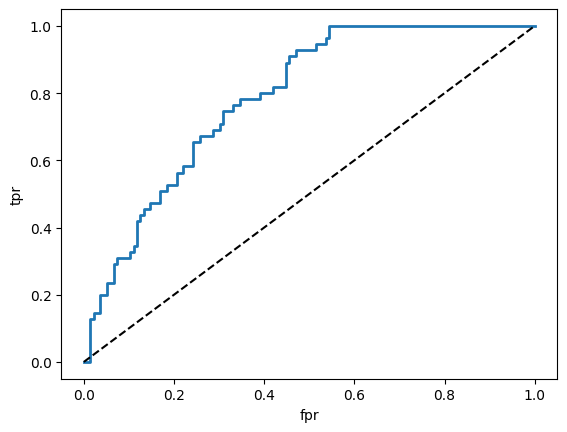

In [ ]:
fpr, tpr, thresholds = roc_curve(test_y, prob_y[:,1])
auc = roc_auc_score(test_y, prob_y[:,1])
plt.plot(fpr, tpr, linewidth=2)
plt.plot([0, 1], [0, 1], 'k--') # dashed diagonal
plt.xlabel('fpr')
plt.ylabel('tpr')
print(f'auc:{auc}')
# auc:0.7885026737967915

#### Test

In [ ]:
from sklearn.model_selection import RandomizedSearchCV

# purged K-Fold
n_cv = 6
t1 = pd.Series(train_y.index.values, index=train_y.index)
cv = PKFold(n_splits= n_cv, samples_info_sets=t1, pct_embargo=0.1)  # Purged K-Fold 객체 생성


bc_params = {
    'n_estimators': [5, 10, 20, 50, 100], # BaggingClassifier가 만들 개별 모델(트리)의 수
    'max_features': [0.5, 0.7, 0.9, 1.0], # BaggingClassifier가 각 기본 모델 학습에 사용할 특성 샘플링 비율
    'bootstrap_features': [False, True],  # BaggingClassifier가 특성 샘플링 시 복원 추출 여부 (True 시 max_features 유효)
    'estimator__max_depth': [3, 5, 10, 20, None], # 내부 RandomForestClassifier의 각 트리의 최대 깊이
    'estimator__max_features': [None, 'sqrt', 'log2', 'auto'], # 내부 RandomForestClassifier의 각 트리 노드 분할 시 고려할 특성 개수
    'estimator__min_samples_leaf': [1, 3, 5, 10] # 내부 RandomForestClassifier의 각 트리의 리프 노드 최소 샘플 수
}

rfc = RandomForestClassifier(class_weight='balanced')

random_search_rfc = RandomizedSearchCV(
    rfc,                   # 튜닝할 모델 (BaggingClassifier)
    bc_params,             # 하이퍼파라미터 탐색 공간
    n_iter=20,             # 무작위 조합 탐색 횟수 (예: 50번)
    cv=cv,                 # 교차 검증 전략
    scoring='accuracy',    # 평가 지표 (예: 정확도)
    random_state=42,       # 재현성을 위한 난수 시드
    n_jobs=-1,             # 병렬 처리
    verbose=1              # 학습 진행 상황 출력
)

gs_rfc.fit(train_x, train_y)
# RandomForestClassifier(class_weight='balanced', max_depth=3, max_features=None, min_samples_leaf=3)

Fitting 4 folds for each of 288 candidates, totalling 1152 fits


GridSearchCV(cv=PKFold(n_splits=4, pct_embargo=0,
    samples_info_sets=time
2018-01-01 00:43:00   2018-01-01 00:43:00
2018-01-01 00:44:00   2018-01-01 00:44:00
2018-01-01 00:45:00   2018-01-01 00:45:00
2018-01-01 00:46:00   2018-01-01 00:46:00
2018-01-01 00:47:00   2018-01-01 00:47:00
                              ...
2018-01-01 11:48:00   201...0   2018-01-01 11:51:00
2018-01-01 11:52:00   2018-01-01 11:52:00
Length: 670, dtype: datetime64[ns]),
             estimator=BaggingClassifier(estimator=RandomForestClassifier(class_weight='balanced')),
             n_jobs=-1,
             param_grid={'bootstrap_features': [False, True],
                         'estimator__max_depth': [3, 5, 10, 20],
                         'estimator__max_features': [None, 'auto'],
                         'estimator__min_samples_leaf': [3, 5, 10],
                         'max_features': [0.5, 0.7],
                         'n_estimators': [5, 10, 20]},
             verbose=1)

In [123]:
gs_rfc_best = gs_rfc.best_estimator_
gs_rfc_best.fit(train_x, train_y)
# 최적의 모델을 사용하여 예측
pred_y = gs_rfc_best.predict(test_x)
prob_y = gs_rfc_best.predict_proba(test_x)

# 모델 평가
confusion = confusion_matrix(test_y, pred_y)
accuracy  = accuracy_score(test_y, pred_y)
precision = precision_score(test_y, pred_y)
recall    = recall_score(test_y, pred_y)

print('================= confusion matrix ====================')
print(confusion)
print('=======================================================')
print(f'정확도:{accuracy}, 정밀도:{precision}, 재현율:{recall}')

================= confusion matrix ====================
[[80 56]
 [12 43]]
정확도:0.643979057591623, 정밀도:0.43434343434343436, 재현율:0.7818181818181819


auc:0.7828877005347593


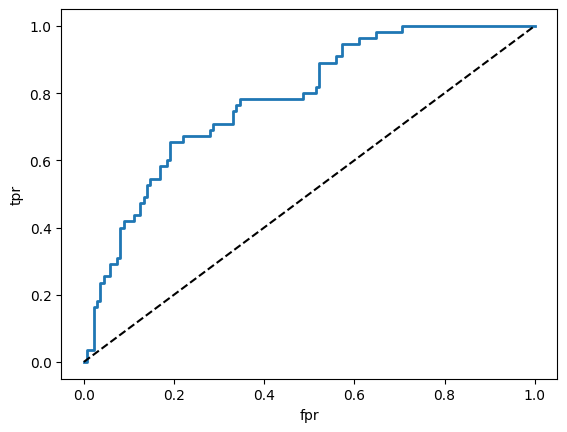

In [124]:
fpr, tpr, thresholds = roc_curve(test_y, prob_y[:,1])
auc = roc_auc_score(test_y, prob_y[:,1])
plt.plot(fpr, tpr, linewidth=2)
plt.plot([0, 1], [0, 1], 'k--') # dashed diagonal
plt.xlabel('fpr')
plt.ylabel('tpr')
print(f'auc:{auc}')

### test 2

In [126]:
%pip install xgboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 2.0 MB/s eta 0:00:0000:0100:01

[notice] A new release of pip is available: 24.0 -> 25.1.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [135]:
from xgboost import XGBClassifier

model = XGBClassifier(random_state=0, eval_metric='auc')
model.fit(train_x, train_y)
pred_y = model.predict(test_x)
prob_y = model.predict_proba(test_x)
confusion = confusion_matrix(test_y, pred_y)
accuracy  = accuracy_score(test_y, pred_y)
precision = precision_score(test_y, pred_y)
recall    = recall_score(test_y, pred_y)
auc = roc_auc_score(test_y, prob_y[:,1])
print('================= confusion matrix ====================')
print(confusion)
print('=======================================================')
print(f'정확도:{accuracy}, 정밀도:{precision}, 재현율:{recall}, auc:{auc}')


================= confusion matrix ====================
[[70 66]
 [15 40]]
정확도:0.5759162303664922, 정밀도:0.37735849056603776, 재현율:0.7272727272727273, auc:0.7163101604278075


In [134]:
model = XGBClassifier(eval_metric='auc')
bag_xgboost = BaggingClassifier(model) # BaggingClassifier(estimator=) # 부트스트랩샘플링해서 데이터를 학습 시키겠다는 의미
bag_xgboost.fit(train_x, train_y)
pred_y = bag_xgboost.predict(test_x)
prob_y = bag_xgboost.predict_proba(test_x)
confusion = confusion_matrix(test_y, pred_y)
accuracy  = accuracy_score(test_y, pred_y)
precision = precision_score(test_y, pred_y)
recall    = recall_score(test_y, pred_y)
auc = roc_auc_score(test_y, prob_y[:,1])
print('================= confusion matrix ====================')
print(confusion)
print('=======================================================')
print(f'정확도:{accuracy}, 정밀도:{precision}, 재현율:{recall}, auc:{auc}')

================= confusion matrix ====================
[[66 70]
 [10 45]]
정확도:0.581151832460733, 정밀도:0.391304347826087, 재현율:0.8181818181818182, auc:0.7553475935828877


In [141]:

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, StratifiedKFold
from xgboost import XGBClassifier
from hyperopt import fmin, tpe, hp, Trials, STATUS_OK
from sklearn.metrics import roc_auc_score


params = {'max_depth': hp.randint('max_depth', 3, 15), 
          'min_child_weight': hp.quniform('min_child_weight', 1, 6, 1),
          'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 0.95),
          'learning_rate': hp.uniform('learning_rate', 0.01, 0.2),
          'subsample': hp.uniform('subsample', 0.6, 1)
}

def objective_func(search_space):
    model = XGBClassifier(n_estimators=100, 
                          **search_space,
                          n_jobs=-1, # n_jobs는 -1로 설정하여 모든 코어 사용
                          )
    cv = StratifiedKFold(n_splits=5, shuffle=True) # StratifiedKFold로 5개 k-fold 생성
    scores = cross_val_score(model, train_x, train_y, cv=cv, scoring='roc_auc') # 각 k-fold에 대해 roc_auc값 계산
        
    # HyperOpt는 목적함수의 최소값을 위한 입력값을 찾으므로 -1을 곱한 뒤 반환. 
    return -1 * np.mean(scores)

trials = Trials()
best = fmin(fn=objective_func, # 목적 함수
             space=params, # 하이퍼 파라미터 검색 공간
             algo=tpe.suggest, # TPE 알고리즘을 사용하여 하이퍼 파라미터 조합을 생성
             max_evals=100, ## max_evals는 100으로 설정하여 100번의 하이퍼 파라미터 조합을 평가.
             trials=trials, ## trials는 HyperOpt의 평가 이력 저장을 위한 객체로
             rstate=np.random.default_rng(seed=30) # seed 고정
            )
print('best hyper-parameter: ', best)


# Access the best score from the trials object
best_score = -min(trials.losses())
print("Best score:", best_score)

opt_model = XGBClassifier(**best, 
                          n_estimators=500, 
                          random_state=0,
                          early_stopping_rounds=100,
                          eval_metric='auc'
                          )

evals = [(train_x, train_y), (test_x, test_y)]
opt_model.fit(train_x, train_y, eval_set=evals, verbose=True)

100%|██████████| 100/100 [05:04<00:00,  3.05s/trial, best loss: -0.987734155669712]
best hyper-parameter:  {'colsample_bytree': 0.7554485450885401, 'learning_rate': 0.14316412288155383, 'max_depth': 9, 'min_child_weight': 1.0, 'subsample': 0.9343564361479221}
Best score: 0.987734155669712
[0]	validation_0-auc:0.98766	validation_1-auc:0.68590
[1]	validation_0-auc:0.99427	validation_1-auc:0.64345
[2]	validation_0-auc:0.99880	validation_1-auc:0.67828
[3]	validation_0-auc:0.99885	validation_1-auc:0.68148
[4]	validation_0-auc:0.99908	validation_1-auc:0.68824
[5]	validation_0-auc:0.99935	validation_1-auc:0.70120
[6]	validation_0-auc:0.99940	validation_1-auc:0.71023
[7]	validation_0-auc:0.99963	validation_1-auc:0.72560
[8]	validation_0-auc:0.99988	validation_1-auc:0.73930
[9]	validation_0-auc:0.99992	validation_1-auc:0.73984
[10]	validation_0-auc:0.99996	validation_1-auc:0.73710
[11]	validation_0-auc:0.99995	validation_1-auc:0.73563
[12]	validation_0-auc:0.99997	validation_1-auc:0.74271
[13]	

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.7554485450885401, device=None,
              early_stopping_rounds=100, enable_categorical=False,
              eval_metric='auc', feature_types=None, feature_weights=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.14316412288155383,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=9, max_leaves=None,
              min_child_weight=1.0, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=500, n_jobs=None,
              num_parallel_tree=None, ...)

In [142]:
# Access the best score from the trials object
best_score = -min(trials.losses())
print("Best score:", best_score)

Best score: 0.987734155669712


In [145]:
# 4. 최적 하이퍼 파라미터로 XGBClassifier 학습 및 평가

# n_estimators를 500증가 후 최적으로 찾은 하이퍼 파라미터를 기반으로 학습과 예측 수행.
# evaluation metric을 auc로, early stopping은 100 으로 설정하고 학습 수행. 

opt_model = XGBClassifier(**best, 
                          n_estimators=500, 
                          random_state=0,
                          early_stopping_rounds=100,
                          eval_metric='auc'
                          )

evals = [(train_x, train_y), (test_x, test_y)]
opt_model.fit(train_x, train_y, eval_set=evals, verbose=True)

# 최적 하이퍼 파라미터로 학습된 opt_model을 테스트 세트에 적용하여 roc_auc 평가 수행.
pred_proba = opt_model.predict_proba(test_x)[:, 1]
print(roc_auc_score(test_y, pred_proba))

[0]	validation_0-auc:0.98766	validation_1-auc:0.68590


[1]	validation_0-auc:0.99427	validation_1-auc:0.64345
[2]	validation_0-auc:0.99880	validation_1-auc:0.67828
[3]	validation_0-auc:0.99885	validation_1-auc:0.68148
[4]	validation_0-auc:0.99908	validation_1-auc:0.68824
[5]	validation_0-auc:0.99935	validation_1-auc:0.70120
[6]	validation_0-auc:0.99940	validation_1-auc:0.71023
[7]	validation_0-auc:0.99963	validation_1-auc:0.72560
[8]	validation_0-auc:0.99988	validation_1-auc:0.73930
[9]	validation_0-auc:0.99992	validation_1-auc:0.73984
[10]	validation_0-auc:0.99996	validation_1-auc:0.73710
[11]	validation_0-auc:0.99995	validation_1-auc:0.73563
[12]	validation_0-auc:0.99997	validation_1-auc:0.74271
[13]	validation_0-auc:0.99999	validation_1-auc:0.74432
[14]	validation_0-auc:0.99999	validation_1-auc:0.74325
[15]	validation_0-auc:0.99999	validation_1-auc:0.74111
[16]	validation_0-auc:0.99999	validation_1-auc:0.74358
[17]	validation_0-auc:1.00000	validation_1-auc:0.73930
[18]	validation_0-auc:0.99999	validation_1-auc:0.74759
[19]	validation_0-a

In [148]:
opt_model = XGBClassifier(**best, 
                          n_estimators=500, 
                          random_state=0,
                          eval_metric='auc'
                          )

bag_xgboost = BaggingClassifier(opt_model) # BaggingClassifier(estimator=) # 부트스트랩샘플링해서 데이터를 학습 시키겠다는 의미
bag_xgboost.fit(train_x, train_y)
pred_y = bag_xgboost.predict(test_x)
prob_y = bag_xgboost.predict_proba(test_x)
confusion = confusion_matrix(test_y, pred_y)
accuracy  = accuracy_score(test_y, pred_y)
precision = precision_score(test_y, pred_y)
recall    = recall_score(test_y, pred_y)
auc = roc_auc_score(test_y, prob_y[:,1])
print('================= confusion matrix ====================')
print(confusion)
print('=======================================================')
print(f'정확도:{accuracy}, 정밀도:{precision}, 재현율:{recall}, auc:{auc}')

================= confusion matrix ====================
[[69 67]
 [10 45]]
정확도:0.5968586387434555, 정밀도:0.4017857142857143, 재현율:0.8181818181818182, auc:0.7618983957219251


In [137]:
from lightgbm import LGBMClassifier

lgbm_clf = LGBMClassifier(n_estimators=500, 
                          num_leaves=32, 
                          n_jobs=-1, 
                          early_stop_round = 10,
                          metric='auc',
                          boost_from_average=False,
                          verbose=-1
                         )

lgbm_clf.fit(train_x, train_y)
pred_y = model.predict(test_x)
prob_y = model.predict_proba(test_x)
confusion = confusion_matrix(test_y, pred_y)
accuracy  = accuracy_score(test_y, pred_y)
precision = precision_score(test_y, pred_y)
recall    = recall_score(test_y, pred_y)
auc = roc_auc_score(test_y, prob_y[:,1])
print('================= confusion matrix ====================')
print(confusion)
print('=======================================================')
print(f'정확도:{accuracy}, 정밀도:{precision}, 재현율:{recall}, auc:{auc}')


================= confusion matrix ====================
[[70 66]
 [15 40]]
정확도:0.5759162303664922, 정밀도:0.37735849056603776, 재현율:0.7272727272727273, auc:0.7163101604278075


In [138]:
lgbm_clf = LGBMClassifier(n_estimators=500, 
                          num_leaves=32, 
                          n_jobs=-1, 
                          early_stop_round = 10,
                          metric='auc',
                          boost_from_average=False,
                          verbose=-1
                         )

bag_lightGBM = BaggingClassifier(lgbm_clf) # BaggingClassifier(estimator=) # 부트스트랩샘플링해서 데이터를 학습 시키겠다는 의미
bag_lightGBM.fit(train_x, train_y)
pred_y = bag_xgboost.predict(test_x)
prob_y = bag_xgboost.predict_proba(test_x)
confusion = confusion_matrix(test_y, pred_y)
accuracy  = accuracy_score(test_y, pred_y)
precision = precision_score(test_y, pred_y)
recall    = recall_score(test_y, pred_y)
auc = roc_auc_score(test_y, prob_y[:,1])
print('================= confusion matrix ====================')
print(confusion)
print('=======================================================')
print(f'정확도:{accuracy}, 정밀도:{precision}, 재현율:{recall}, auc:{auc}')

================= confusion matrix ====================
[[66 70]
 [10 45]]
정확도:0.581151832460733, 정밀도:0.391304347826087, 재현율:0.8181818181818182, auc:0.7553475935828877
